# Module 3: Machine Learning
## Sprint 3: Unsupervised Learning & Hyperparameter Tuning
## Part 5: LendingClub

### About the dataset
The dataset consists of loan data from LendingClub. It is obtained from a publicly accessible source and includes two separate datasets. <br>
<a href="https://storage.googleapis.com/335-lending-club/lending-club.zip"> the link to the dataset </a>  <br> 
The dataset for accepted loans contains 2.2 million records and encompasses 151 features. <br>
The dataset for rejected loans contains 27.6 million records and includes 9 features.

### Project goal
The goal of this project is to explore and analyze the loan data from LendingClub and use the insights to accomplish three main tasks:
* Classification of loans into accepted or rejected
* Classification of loan grades
* Predict the interest rate (regression task)

### Project Outline

#### Pre-processing data using PySpark. 
Removing some features and faulty records, inputting missing values, and transforming the data for EDA and prediction. <br>
Ultimately, I produce two datasets - smaller for loan status prediction and bigger for loan grade and interest rate prediction.

#### EDA of loan status dataset.
Exploring categoric and numeric variables and their relation with loan status feature. <br>
Performing a z-test on numeric variables to determine which of them have predictive value.

#### EDA of loan grade dataset.
Exploring categoric and numeric variables and their relation with grade feature. <br>
Performing $\chi^2$ test to determine if there is a relationship between grade and categorical features. <br>
I am performing the Anova-F test to find the most important numeric features.

#### Modeling
*   Loan status prediction
*   Loan grade prediction
*   Loan interest rate prediction

#### Conclusion and further improvements.

# Loading the data

In [ ]:
#!pip install pyspark
import io
import requests
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import proportions_ztest
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
spark = (
    SparkSession.builder.master('local[*]')
    .appName('YourAppName')
    .config('spark.executor.memory', '6g')
    .config('spark.driver.memory', '6g')
    .getOrCreate()
)

In [ ]:
url = 'https://storage.googleapis.com/335-lending-club/lending-club.zip'
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    zip_file.extractall()

In [ ]:
sdf_rejected = spark.read.csv('/content/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv', 
                              header=True)
sdf_accepted = spark.read.csv('/content/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv', 
                              header=True)

In [ ]:
print(f'Dataset accepted: rows {sdf_accepted.count()}; columns {len(sdf_accepted.columns)}')
print(f'Dataset rejected: rows {sdf_rejected.count()}; columns {len(sdf_rejected.columns)}')

Dataset accepted: rows 2260701; columns 151
Dataset rejected: rows 27648741; columns 9


In [ ]:
sdf_accepted.show(10)

+--------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+-----------+----------+--------------------+----+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-

In [ ]:
sdf_rejected.show(10)

+----------------+----------------+--------------------+----------+--------------------+--------+-----+-----------------+-----------+
|Amount Requested|Application Date|          Loan Title|Risk_Score|Debt-To-Income Ratio|Zip Code|State|Employment Length|Policy Code|
+----------------+----------------+--------------------+----------+--------------------+--------+-----+-----------------+-----------+
|          1000.0|      2007-05-26|Wedding Covered b...|     693.0|                 10%|   481xx|   NM|          4 years|        0.0|
|          1000.0|      2007-05-26|  Consolidating Debt|     703.0|                 10%|   010xx|   MA|         < 1 year|        0.0|
|         11000.0|      2007-05-27|Want to consolida...|     715.0|                 10%|   212xx|   MD|           1 year|        0.0|
|          6000.0|      2007-05-27|             waksman|     698.0|              38.64%|   017xx|   MA|         < 1 year|        0.0|
|          1500.0|      2007-05-27|              mdrigo|     5

All the columns are of type string.

In [ ]:
sdf_accepted.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: string (nullable = true)
 |-- funded_amnt: string (nullable = true)
 |-- funded_amnt_inv: string (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string 

In [ ]:
sdf_rejected.printSchema()

root
 |-- Amount Requested: string (nullable = true)
 |-- Application Date: string (nullable = true)
 |-- Loan Title: string (nullable = true)
 |-- Risk_Score: string (nullable = true)
 |-- Debt-To-Income Ratio: string (nullable = true)
 |-- Zip Code: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Employment Length: string (nullable = true)
 |-- Policy Code: string (nullable = true)



# Data pre-processing

In [ ]:
sdf_accepted.groupBy('id').agg(f.count('*').alias('count')).filter(f.col('count') > 1).show()

+---+-----+
| id|count|
+---+-----+
+---+-----+



There are no duplicate records in the dataset.

## Removing faulty records

In [ ]:
t = sdf_accepted.filter((f.length(f.col('zip_code')) != 5) | 
                        (f.substring(f.col('zip_code'), -2, 2) != 'xx'))
t.select(t.columns[t.columns.index('url') + 1:]).show(10)
print('Records with errors', t.count())
sdf_accepted = sdf_accepted.join(t.select('id'), on='id', how='left_anti')

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+----------------------+----------------------+--------------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+-----------------+------------------+------------------+------------------+----------+-----------------------+------------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+----------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+-------+-----------+------------+--------------------+-----------+-------

Drop records with missing values in specified columns

In [ ]:
sdf_accepted = sdf_accepted.dropna(subset=['grade', 'sub_grade', 'int_rate', 
                                           'loan_amnt', 'addr_state'])

## Removing columns

Cheking for missing values in all columns and removing the columns with more than 50% of data missing:



In [ ]:
def get_null_values_per_col(df):
    """Displays the percentage of missing values per column."""
    total_rows = df.count()
    null_counts = df.agg(*[f.count(f.when(f.isnan(c) | 
                                          f.col(c).isNull(), c)).alias(c) for c in df.columns])
    null_percentages = {c: (count / total_rows) * 100 for c, 
                        count in zip(df.columns, null_counts.first())}
    sorted_null_percentages = dict(sorted(null_percentages.items(), 
                                          key=lambda item: item[1], reverse=True))
    for column, percentage in sorted_null_percentages.items():
        print(f'{column}: {percentage:.2f}%')
    return sorted_null_percentages

sorted_null_percentages = get_null_values_per_col(sdf_accepted)

member_id: 100.00%
orig_projected_additional_accrued_interest: 99.62%
hardship_type: 99.52%
hardship_reason: 99.52%
hardship_status: 99.52%
deferral_term: 99.52%
hardship_amount: 99.52%
hardship_start_date: 99.52%
hardship_end_date: 99.52%
payment_plan_start_date: 99.52%
hardship_length: 99.52%
hardship_dpd: 99.52%
hardship_loan_status: 99.52%
hardship_payoff_balance_amount: 99.52%
hardship_last_payment_amount: 99.52%
debt_settlement_flag_date: 98.49%
settlement_status: 98.49%
settlement_date: 98.49%
settlement_amount: 98.49%
settlement_percentage: 98.49%
settlement_term: 98.49%
sec_app_mths_since_last_major_derog: 98.41%
sec_app_revol_util: 95.30%
revol_bal_joint: 95.22%
sec_app_fico_range_low: 95.22%
sec_app_fico_range_high: 95.22%
sec_app_earliest_cr_line: 95.22%
sec_app_inq_last_6mths: 95.22%
sec_app_mort_acc: 95.22%
sec_app_open_acc: 95.22%
sec_app_open_act_il: 95.22%
sec_app_num_rev_accts: 95.22%
sec_app_chargeoff_within_12_mths: 95.22%
sec_app_collections_12_mths_ex_med: 95.22%


In [ ]:
columns_to_remove = [column for column, percentage in 
                     sorted_null_percentages.items() if percentage > 50]
sdf_accepted = sdf_accepted.drop(*columns_to_remove)
sdf_accepted.limit(10).show()
print(f'Columns count {len(sdf_accepted.columns)}')

+--------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+------------------+----------+--------------------+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------------+--------------------+-------------------+--------------------------+-----------+----------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+--------------------+-----------+--------------+

In [ ]:
sorted_null_percentages = get_null_values_per_col(sdf_rejected)

Risk_Score: 66.90%
Employment Length: 3.44%
Loan Title: 0.00%
Policy Code: 0.00%
Zip Code: 0.00%
State: 0.00%
Amount Requested: 0.00%
Application Date: 0.00%
Debt-To-Income Ratio: 0.00%


Removing not useful features and features that are going to be known after the loan is already given.

In [ ]:
cols = ['zip_code', 'url', 'id', 'title', 'policy_code', 'emp_title', 'last_fico_range_high',	
        'last_fico_range_low', 'last_credit_pull_d', 'id', 'last_pymnt_amnt', 'last_pymnt_d', 
        'next_pymnt_d', 'loan_status', 'next_pymnt_d','out_prncp', 'out_prncp_inv', 'total_pymnt', 
        'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
        'collection_recovery_fee']
sdf_accepted = sdf_accepted.drop(*cols)
sdf_rejected = sdf_rejected.drop('Zip Code', 'Policy Code')

In [ ]:
print(f'Columns count {len(sdf_accepted.columns)}')

Columns count 86


In [ ]:
sdf_accepted.groupBy('pymnt_plan').count().orderBy('count', ascending=False).show()
sdf_accepted.groupBy('hardship_flag').count().orderBy('count', ascending=False).show()
sdf_accepted = sdf_accepted.drop('pymnt_plan','hardship_flag')

+----------+-------+
|pymnt_plan|  count|
+----------+-------+
|         n|2259792|
|         y|    620|
+----------+-------+

+-------------+-------+
|hardship_flag|  count|
+-------------+-------+
|            N|2259580|
|            Y|    832|
+-------------+-------+



## Transforming the data

In [ ]:
categorical_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 
                    'loan_status', 'pymnt_plan', 'initial_list_status', 'application_type', 
                    'hardship_flag', 'disbursement_method', 'debt_settlement_flag', 'purpose', 
                    'title', 'addr_state', 'sub_grade']
date_cols = ['issue_d', 'earliest_cr_line', 'last_credit_pull_d']
numeric_cols = list(set(sdf_accepted.columns) - set(categorical_cols) - set(date_cols))

### Categoric columns

Replacing missing values with the most common value:

In [ ]:
sdf_accepted = sdf_accepted.withColumn('term', f.when(f.col('term').like('%60 months%'), 
                                                      f.col('term')).otherwise('36 months'))
sdf_accepted = sdf_accepted.withColumn('application_type', f.when(f.col('application_type').isin(['Individual', 'Joint App']), 
                                                                  f.col('application_type')).otherwise('Individual'))
sdf_accepted = sdf_accepted.withColumn('home_ownership', f.when(f.col('home_ownership').isin(['MORTGAGE', 'RENT', 'OWN']), 
                                                                f.col('home_ownership')).otherwise('MORTGAGE'))
sdf_accepted = sdf_accepted.withColumn('verification_status', f.when(f.col('verification_status').isin(['Not Verified', 'Verified', 'Source Verified']), 
                                                                     f.col('verification_status')).otherwise('Source Verified'))
sdf_accepted = sdf_accepted.withColumn('initial_list_status', f.when(f.col('initial_list_status').isin(['w', 'f']), 
                                                                     f.col('initial_list_status')).otherwise('w'))
sdf_accepted = sdf_accepted.withColumn('disbursement_method', f.when(f.col('disbursement_method').isin(['Cash', 'DirectPay']), 
                                                                     f.col('disbursement_method')).otherwise('Cash'))
sdf_accepted = sdf_accepted.withColumn('debt_settlement_flag', f.when(f.col('debt_settlement_flag').isin(['Y', 'N']), 
                                                                      f.col('debt_settlement_flag')).otherwise('N'))
sdf_accepted = sdf_accepted.withColumn('grade', f.when(f.col('grade').isin(['A', 'B', 'C', 'D', 'E', 'F', 'G']), 
                                                       f.col('grade')).otherwise('C'))

Transforming a date column to year and month columns:

In [ ]:
sdf_rejected = sdf_rejected.withColumn('Debt-To-Income Ratio', f.regexp_replace('Debt-To-Income Ratio', '%', ''))
sdf_rejected = sdf_rejected.withColumn('Application Year', f.split(f.col('Application Date'), '-').getItem(0))
sdf_rejected = sdf_rejected.withColumn('Application Month', f.split(f.col('Application Date'), '-').getItem(1))
sdf_rejected = sdf_rejected.drop('Application Date')

In [ ]:
month_dict = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 
              'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}
sdf_accepted = sdf_accepted.withColumn('Application Month', f.split(f.col('issue_d'), '-').getItem(0))
sdf_accepted = sdf_accepted.withColumn('Application Year', f.split(f.col('issue_d'), '-').getItem(1))
sdf_accepted = sdf_accepted.drop('issue_d')
sdf_accepted = sdf_accepted.withColumn('Application Month', f.when(f.col('Application Month').isin(list(month_dict.keys())), 
                                                                   f.create_map([f.lit(x) for x in sum(month_dict.items(), ())])/
                                                                   .getItem(f.col('Application Month'))))
sdf_accepted = sdf_accepted.drop('issue_d')

Aggregating loan title (loan purpose):

In [ ]:
sdf_accepted = sdf_accepted.withColumn('purpose',
                                        f.when(f.col('purpose').like('%debt%'), 'debt_consolidation')
                                        .when(f.col('purpose').isNull(), 'other')
                                        .otherwise(f.col('purpose'))) \
                           .withColumn('purpose', f.lower(f.regexp_replace(f.col('purpose'), '_', ' ')))

sdf_rejected = sdf_rejected.withColumn('Loan Title', f.lower(f.regexp_replace('Loan Title', '_', ' ')))
sdf_rejected = sdf_rejected.withColumn('Loan Title',
                                        f.when(f.col('Loan Title').like('%credit card%') | 
                                               f.col('Loan Title').like('%cc %'), 
                                               'credit card')
                                        .when(f.col('Loan Title').like('%medical%') | 
                                              f.col('Loan Title').like('%surgery%') | 
                                              f.col('Loan Title').like('%dental%'), 
                                              'medical')
                                        .when(f.col('Loan Title').like('%business%') | 
                                              f.col('Loan Title').like('%capital%')| 
                                              f.col('Loan Title').like('%investment%'), 
                                              'small business')
                                        .when(f.col('Loan Title').like('%green%'), 
                                              'renewable energy')
                                        .when(f.col('Loan Title').like('%moving%') | 
                                              f.col('Loan Title').like('%relocation%'), 
                                              'moving') 
                                        .when(f.col('Loan Title').like('%student%') | 
                                              f.col('Loan Title').like('%education%') | 
                                              f.col('Loan Title').like('%school%') | 
                                              f.col('Loan Title').like('%college%') | 
                                              f.col('Loan Title').like('%learning%') | 
                                              f.col('Loan Title').like('%tuition%'), 
                                              'educational') 
                                        .when(f.col('Loan Title').like('%home improvement%') | 
                                              f.col('Loan Title').like('%home improvment%') | 
                                              f.col('Loan Title').like('%remodel%') | 
                                              f.col('Loan Title').like('%home repair%') | 
                                              f.col('Loan Title').like('%pool%'), 
                                              'home improvement')
                                        .when(f.col('Loan Title').like('%home purchase%') | 
                                              f.col('Loan Title').like('%home loan%') | 
                                              f.col('Loan Title').like('%house loan%') | 
                                              f.col('Loan Title').like('%down payment%') | 
                                              f.col('Loan Title').like('%home%')| 
                                              f.col('Loan Title').like('%house%'), 
                                              'house') 
                                        .when(f.col('Loan Title').like('%refinanc%') | 
                                              f.col('Loan Title').like('%consolidat%'), 
                                              'debt consolidation')
                                        .when(f.col('Loan Title').like('%wedding%'), 
                                              'wedding')
                                        .when(f.col('Loan Title').like('%vacation%'), 
                                              'vacation')
                                        .when(f.col('Loan Title').like('%major purchase%'), 
                                              'major purchase')
                                        .when(f.col('Loan Title').like('%car%') | 
                                              f.col('Loan Title').like('%motorcycle%') | 
                                              f.col('Loan Title').like('%auto%') | 
                                              f.col('Loan Title').like('%truck%') | 
                                              f.col('Loan Title').like('%trailer%'), 
                                              'car')
                                        .when(f.col('Loan Title').like('%debt%') | 
                                              f.col('Loan Title').like('%payoff%') | 
                                              f.col('Loan Title').like('%pay off%') | 
                                              f.col('Loan Title').like('%refi%'), 
                                              'debt consolidation')
                                        .otherwise('other'))

Asjusting employment length feature:

In [ ]:
def transform_employment_length_col(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
  """Transforms the employment length column in the DataFrame."""
  df = df.withColumn(col_name,
                      f.when(f.col(col_name) == '10+ years', 10)
                      .when(f.col(col_name) == '< 1 year', 0)
                      .otherwise(f.regexp_extract(f.col(col_name), '\d+', 0)))

  df = df.fillna({col_name: 0})
  return df

In [ ]:
sdf_accepted = transform_employment_length_col(sdf_accepted, 'emp_length')
sdf_rejected = transform_employment_length_col(sdf_rejected, 'Employment Length')

In [ ]:
sdf_rejected.show()

+----------------+------------------+----------+--------------------+-----+-----------------+----------------+-----------------+
|Amount Requested|        Loan Title|Risk_Score|Debt-To-Income Ratio|State|Employment Length|Application Year|Application Month|
+----------------+------------------+----------+--------------------+-----+-----------------+----------------+-----------------+
|          1000.0|           wedding|     693.0|                  10|   NM|                4|            2007|               05|
|          1000.0|debt consolidation|     703.0|                  10|   MA|                0|            2007|               05|
|         11000.0|debt consolidation|     715.0|                  10|   MD|                1|            2007|               05|
|          6000.0|             other|     698.0|               38.64|   MA|                0|            2007|               05|
|          1500.0|             other|     509.0|                9.43|   MD|                0|    

### Numeric columns

Converting two similar columns to their average:

In [ ]:
sdf_accepted = sdf_accepted.withColumn('Risk Score', 
                                       f.round((f.col('fico_range_high') + 
                                                f.col('fico_range_low')) / 2))
sdf_accepted = sdf_accepted.drop('fico_range_high', 'fico_range_low')

numeric_cols = [col for col in numeric_cols if col not in ['fico_range_high', 'fico_range_low']]
numeric_cols.extend(['Risk Score', 'Application Year', 'Application Month'])

Converting numeric columns to integer type:

In [ ]:
for col_name in numeric_cols:
    sdf_accepted = sdf_accepted.withColumn(col_name, 
                                           f.round(sdf_accepted[col_name].cast('int'), 1))
sdf_accepted.select(*numeric_cols).show(10)

+-----------+--------------+--------------------------+-----------+--------------------+--------------------+----------+-----------+---------+---------+----------------+------------+--------------+----------------+-----------+-----------+------------------------+----------------+-------+----------+-----------------+--------------+--------------------------+---------------+------------+---------------+---------------------+--------------------+---------------------+------------------+--------------+-----------+------------------+--------------+---------+---------------------+-------------+-------------+-----------+-----------+------------------+---------------+------------+------------------+--------+--------------------+--------+-----------+--------------+----------+-----------+--------------+-------+---------+---+--------+-----------+--------+-----------+------------+-----------+-----------+-------------------+---------+---------+------+--------+-------+----------+----------------+---

For each column if it has missing values, it gets assigned the median of the column:

In [ ]:
for col_name in numeric_cols:
  median_val = sdf_accepted.select(f.median(f.col(col_name))).first()[0]
  sdf_accepted = sdf_accepted.fillna(median_val, subset=[col_name])

In [ ]:
cols = ['Amount Requested', 'Risk_Score', 'Debt-To-Income Ratio', 'Application Year', 
        'Application Month']
for col_name in cols:
    sdf_rejected = sdf_rejected.withColumn(col_name, 
                                           f.round(sdf_rejected[col_name].cast('int'), 1))
sdf_rejected.select(*cols).show(10)

+----------------+----------+--------------------+----------------+-----------------+
|Amount Requested|Risk_Score|Debt-To-Income Ratio|Application Year|Application Month|
+----------------+----------+--------------------+----------------+-----------------+
|            1000|       693|                  10|            2007|                5|
|            1000|       703|                  10|            2007|                5|
|           11000|       715|                  10|            2007|                5|
|            6000|       698|                  38|            2007|                5|
|            1500|       509|                   9|            2007|                5|
|           15000|       645|                   0|            2007|                5|
|           10000|       693|                  10|            2007|                5|
|            3900|       700|                  10|            2007|                5|
|            3000|       694|                  10|    

Creating 1) loan application status and 2) accepted loans dataframes:

In [ ]:
sdf_rejected = sdf_rejected.withColumn('Status', f.lit('rejected'))
sdf_rejected = sdf_rejected.withColumnRenamed('Risk_Score', 'Risk Score')
cols = sdf_rejected.columns
sdf_rejected.show(10)

+----------------+------------------+----------+--------------------+-----+-----------------+----------------+-----------------+--------+
|Amount Requested|        Loan Title|Risk Score|Debt-To-Income Ratio|State|Employment Length|Application Year|Application Month|  Status|
+----------------+------------------+----------+--------------------+-----+-----------------+----------------+-----------------+--------+
|            1000|           wedding|       693|                  10|   NM|                4|            2007|                5|rejected|
|            1000|debt consolidation|       703|                  10|   MA|                0|            2007|                5|rejected|
|           11000|debt consolidation|       715|                  10|   MD|                1|            2007|                5|rejected|
|            6000|             other|       698|                  38|   MA|                0|            2007|                5|rejected|
|            1500|             oth

In [ ]:
sdf_accepted_copy = spark.createDataFrame(sdf_accepted.rdd, sdf_accepted.schema)
sdf_accepted_copy = sdf_accepted_copy.select('loan_amnt','purpose','Risk Score','dti', 
                                             'addr_state','emp_length', 'Application Year', 
                                             'Application Month')
sdf_accepted_copy = sdf_accepted_copy.withColumn('Status', f.lit('accepted'))
for i in range(len(cols)):
  sdf_accepted_copy = sdf_accepted_copy.withColumnRenamed(sdf_accepted_copy.columns[i], 
                                                          cols[i])
sdf_accepted_copy.show(10)

+----------------+------------------+----------+--------------------+-----+-----------------+----------------+-----------------+--------+
|Amount Requested|        Loan Title|Risk Score|Debt-To-Income Ratio|State|Employment Length|Application Year|Application Month|  Status|
+----------------+------------------+----------+--------------------+-----+-----------------+----------------+-----------------+--------+
|            7500|debt consolidation|       687|                  37|   FL|               10|            2015|               12|accepted|
|           22000|debt consolidation|       667|                  22|   MI|               10|            2015|               12|accepted|
|           19225|debt consolidation|       712|                  18|   OH|                0|            2015|               12|accepted|
|           16775|debt consolidation|       677|                  29|   GA|                1|            2015|               12|accepted|
|            6000|               c

In [ ]:
sdf_status = sdf_rejected.union(sdf_accepted_copy)
sdf_accepted = sdf_accepted.withColumn('emp_length', 
                                       f.round(sdf_accepted['emp_length'].cast('int'), 1))
sdf_status = sdf_status.withColumn('Employment Length', 
                                   f.round(sdf_status['Employment Length'].cast('int'), 1))
sdf_status.show(10)

+----------------+------------------+----------+--------------------+-----+-----------------+----------------+-----------------+--------+
|Amount Requested|        Loan Title|Risk Score|Debt-To-Income Ratio|State|Employment Length|Application Year|Application Month|  Status|
+----------------+------------------+----------+--------------------+-----+-----------------+----------------+-----------------+--------+
|            1000|           wedding|       693|                  10|   NM|                4|            2007|                5|rejected|
|            1000|debt consolidation|       703|                  10|   MA|                0|            2007|                5|rejected|
|           11000|debt consolidation|       715|                  10|   MD|                1|            2007|                5|rejected|
|            6000|             other|       698|                  38|   MA|                0|            2007|                5|rejected|
|            1500|             oth

# Explanatory data analysis

### Functions needed for plotting

In [ ]:
def draw_feature(data: pd.DataFrame, feature: str, size: list) -> None:
  """Draws a plot with two subplots for the given feature and loan status in the input data.

  Args:
      data (pd.DataFrame): The input DataFrame containing the data to be plotted.
      feature (str): The name of the feature to be visualized.
      size (list): A list specifying the size of the plot in inches [width, height].

  Returns:
      None.
  """
  palette = {'rejected': sns.color_palette()[0], 'accepted': sns.color_palette()[1]}
  data = data.copy()
  data[feature].fillna('Unknown', inplace=True)
  if np.isin(data[feature].iloc[0], ['accepted', 'rejected']):
      data[feature] = [feature if x == 'accepted' else 'rejected ' + feature for x 
                      in data[feature]]
  t = (
      data.groupby(['Status'])[feature]
      .value_counts()
      .round(2)
      .reset_index(name='count')
  )
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(size[0], size[1]))
  sns.barplot(
      data=t,
      x='count',
      y=feature,
      ax=axs[0],
      hue='Status',
      palette=palette,
      edgecolor='black',
      linewidth=1,
      order=sorted(t[feature].unique()),
  )
  axs[0].set_title('Number of people that had application accepted', fontsize=14)
  for container in axs[0].containers:
      axs[0].bar_label(container, padding=5)

  sns.histplot(
      data=data.sort_values(by=[feature, 'Status'], ascending=[True, False]),
      y=feature,
      ax=axs[1],
      hue='Status',
      multiple='fill',
      stat='proportion',
      discrete=True,
      shrink=0.5,
      palette=palette,
      legend=False,
  )
  axs[1].set_title('Proportion of people that had application accepted', fontsize=14)
  for container in axs[1].containers:
      labels = [f'{val:.2f}' for val in container.datavalues]
      labels = ['' if x == '0.00' else x for x in labels]
      axs[1].bar_label(container, labels=labels, label_type='center')

  fig.suptitle(feature, fontsize=18)
  for ax in axs.flat:
      ax.margins(x=0.1)
      ax.set(ylabel=None)
      ax.set(xlabel=None)
  plt.show()

In [ ]:
def draw_feature_grade(data: pd.DataFrame, feature: str, size: list) -> None:
  """Draws a plot with two subplots for the given feature and loan grade in the input data.

  Args:
      data: A pandas DataFrame containing the input data to be plotted.
      feature: The name of the feature to be visualized.
      size: A list specifying the size of the plot in inches [width, height].

  Returns:
      None.
  """
  palette = {'A': sns.color_palette()[0], 
             'B': sns.color_palette()[1],
             'C': sns.color_palette()[2],
             'D': sns.color_palette()[3],
             'E': sns.color_palette()[4],
             'F': sns.color_palette()[5],
             'G': sns.color_palette()[6]
             }
  data = data.copy()
  data[feature].fillna('Unknown', inplace=True)

  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(size[0], size[1]))

  sns.countplot(
    data=df_accepted_subset.sort_values(by=[feature, 'grade'], ascending=[True, False]),
    y=feature,
    ax=axs[0],
    color = sns.color_palette()[0]
  )
  axs[0].set_title('Proportion of people that had application accepted', fontsize=14)

  sns.histplot(
    data=df_accepted_subset.sort_values(by=[feature, 'grade'], ascending=[True, False]),
    y=feature,
    ax=axs[1],
    hue='grade',
    multiple='fill',
    stat='proportion',
    discrete=True,
    shrink=0.5,
    palette=palette,
    legend=False,
  )
  axs[1].set_title('Proportion of people that had application accepted', fontsize=14)

  fig.suptitle(feature, fontsize=18)
  for ax in axs.flat:
      ax.margins(x=0.1)
      ax.set(ylabel=None)
      ax.set(xlabel=None)
  plt.subplots_adjust(wspace=0.4)
  plt.show()

In [ ]:
def plot_count_and_proportion(df: pd.DataFrame, feature: str) -> None:
  """Create a visualization of a feature's distribution and its relationship
  with stroke occurrence in a dataset.

  Args:
      df (pd.DataFrame): The input DataFrame containing the data.
      feature (str): The name of the feature to be visualized.

  Returns:
      None. The function plots two subplots using matplotlib and seaborn libraries.
  """
  palette = {'rejected': sns.color_palette()[0], 
             'accepted': sns.color_palette()[1]}
  fig, axes = plt.subplots(1, 2, figsize=(20, 4))
  fig.suptitle(feature + ' distribution and stroke', fontsize=16)
  sns.histplot(
      ax=axes[0],
      data=df[[feature, 'Status']],
      x=feature,
      hue='Status',
      palette=palette,
      multiple='stack',
      bins=20,
  )
  axes[0].set_title('Number of people with stroke in each group')
  sns.histplot(
      ax=axes[1],
      data=df[[feature, 'Status']],
      x=feature,
      hue='Status',
      palette=palette,
      multiple='fill',
      bins=20,
  )
  axes[1].set_title('Proportion of stroke accidents in each group')
  axes[1].set_ylabel('Proportion')
  plt.show()

In [ ]:
def perform_two_sample_prop_z_test(df: pd.DataFrame, feature: str, val: tuple) -> None:
  """Performs proportions z-test on data split by a categorical feature.
  Args:
      df (pd.DataFrame): the dataset containing the feature and target column.
      feature (str): the feature column to be used to split the data.
      val (tuple): a tuple containing two values representing the categories to compare.

  Returns:
      None: the function prints the z-value and p-value of the two-sample proportions z-test.
  """
  t1 = df[df[feature]==val[0]]['rejected'].value_counts()
  t2 = df[df[feature]==val[1]]['accepted'].value_counts()

  t_value, p_value = proportions_ztest(
      count=[t1['Yes'], t2['Yes']], 
      nobs=[t1.sum(), t2.sum()], 
      alternative='two-sided')
  print(f'z-value: {np.round(t_value,3)}, p-value: {p_value}')

## Subsetting the pyspark dataframe for EDA
I select 2% of all loans dataframe and 10 % of accepted loans dataframe.

In [ ]:
sdf_subset = sdf_status.sample(False, 0.02, seed=40)
pdf_subset = sdf_subset.toPandas()

In [ ]:
print('Subset size:', pdf_subset.shape)
pdf_subset.head()

Subset size: (599014, 8)


,Amount Requested,Loan Title,Debt-To-Income Ratio,State,Employment Length,Application Year,Application Month,Status
0,15000,debt consolidation,15,MN,0,2007,5,rejected
1,8000,other,11,AZ,1,2007,6,rejected
2,17000,credit card,5,MD,4,2007,6,rejected
3,5000,other,14,MO,0,2007,6,rejected
4,1000,other,13,CT,0,2007,6,rejected


In [ ]:
df_accepted_subset = sdf_accepted.sample(False, 0.1, seed=40)
df_accepted_subset = df_accepted_subset.toPandas()

In [ ]:
print('Subset size:', df_accepted_subset.shape)
df_accepted_subset.head()

Subset size: (225626, 84)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,debt_settlement_flag,Application Month,Application Year,Risk Score
0,22000,22000,22000,60 months,17,558,D,D4,10,MORTGAGE,...,0,232758,43464,17200,10358,Cash,N,12,2015,667
1,6000,6000,6000,36 months,10,195,B,B4,10,MORTGAGE,...,0,322369,29190,6300,36750,Cash,Y,12,2015,697
2,6000,6000,6000,36 months,9,193,B,B3,1,RENT,...,0,54701,35700,12900,38801,Cash,N,12,2015,672
3,28000,28000,27950,60 months,17,699,D,D3,10,MORTGAGE,...,1,276858,24252,15900,15000,Cash,N,12,2015,697
4,12000,12000,12000,36 months,13,410,C,C4,10,MORTGAGE,...,0,46506,33426,5900,34406,Cash,N,12,2015,662


## EDA on loan status data (accepted/rejected)

In [ ]:
t1 = pdf_subset['Status'].value_counts()
t2 = pdf_subset['Status'].value_counts(normalize=True).round(3)
t = pd.concat([t1, t2], axis=1)
t.columns = ['Status', 'Status %']
t

,Status,Status %
rejected,553679,0.924
accepted,45335,0.076


The data is highly skewed - only 8% of loan applications are accepted.

In [ ]:
pd.DataFrame(pdf_subset.isnull().sum()/len(pdf_subset), columns=['missing values']).round(2)

,missing values
Amount Requested,0.00
Loan Title,0.00
Risk Score,0.62
Debt-To-Income Ratio,0.00
State,0.00
Employment Length,0.00
Application Year,0.00
Application Month,0.00
Status,0.00


### Numeric features

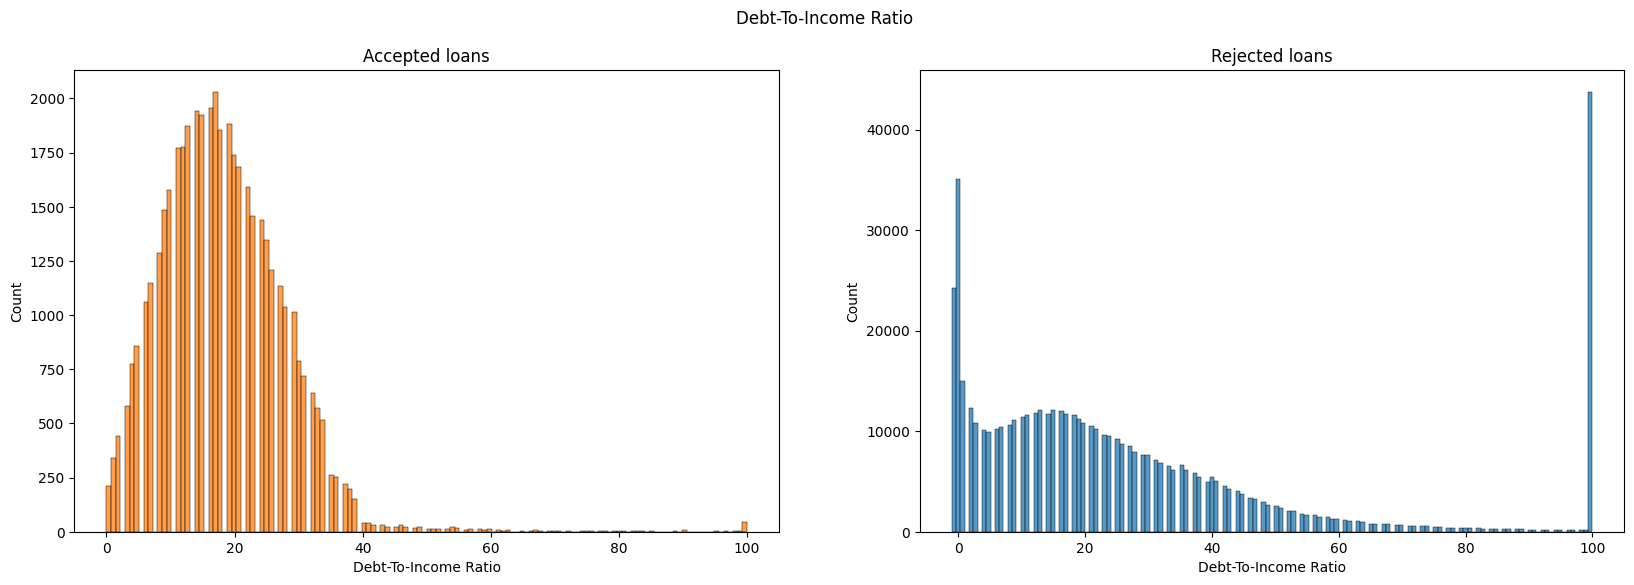

In [ ]:
t = pdf_subset.copy() 
t['Debt-To-Income Ratio'] = [100 if x > 100 else x for x in t['Debt-To-Income Ratio']]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))
fig.suptitle('Debt-To-Income Ratio')

sns.histplot(t[(t['Status']=='accepted')]['Debt-To-Income Ratio'], 
             color=sns.color_palette()[1], ax=ax1)
ax1.set_xlabel('Debt-To-Income Ratio')
ax1.set_ylabel('Count')
ax1.set_title('Accepted loans')

sns.histplot(t[(t['Status']=='rejected')]['Debt-To-Income Ratio'], 
             color=sns.color_palette()[0], ax=ax2)
ax2.set_xlabel('Debt-To-Income Ratio')
ax2.set_ylabel('Count')
ax2.set_title('Rejected loans')

plt.show()

In [ ]:
pdf_subset[['Debt-To-Income Ratio', 'Status']].groupby('Status')['Debt-To-Income Ratio']/
    .agg([np.mean, np.median]).round(2)

,mean,median
Status,,
accepted,18.34,17.0
rejected,142.65,19.0


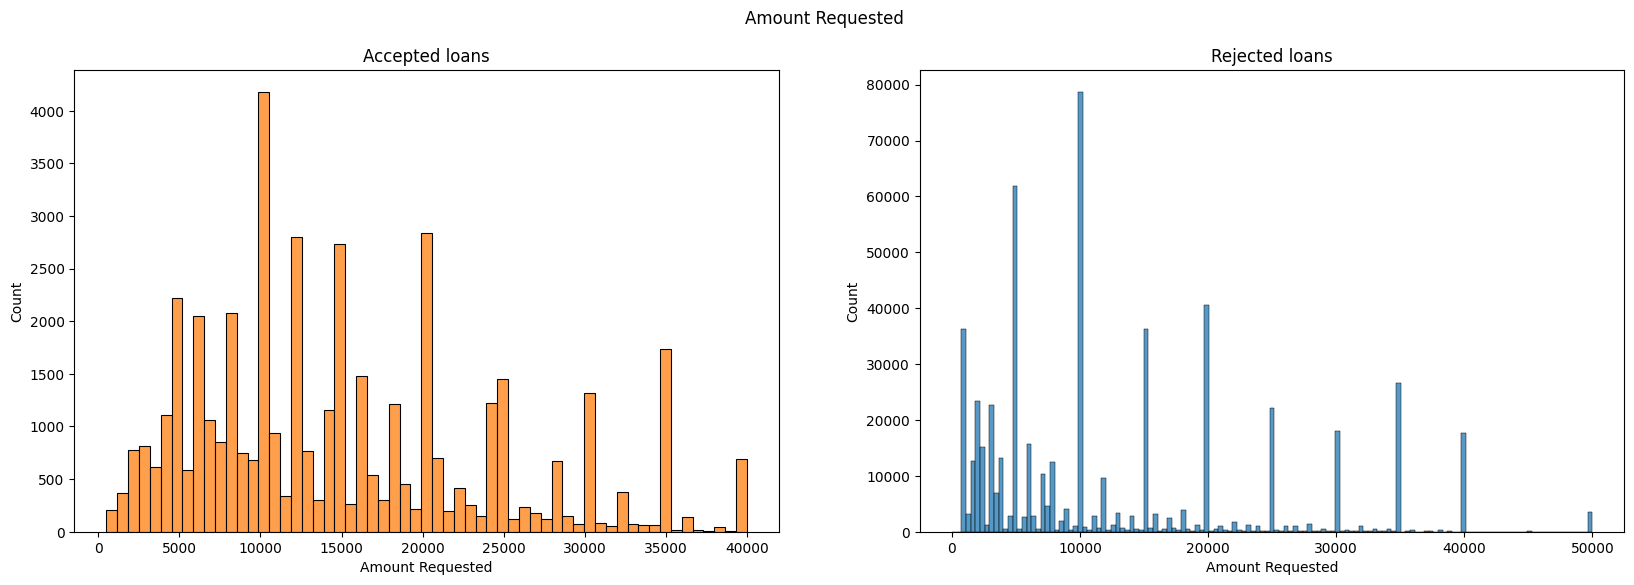

In [ ]:
t = pdf_subset.copy() 
t['Amount Requested'] = [50000 if x > 50000 else x for x in t['Amount Requested']]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))
fig.suptitle('Amount Requested')

sns.histplot(t[(t['Status']=='accepted')]['Amount Requested'], 
             color=sns.color_palette()[1], ax=ax1)
ax1.set_xlabel('Amount Requested')
ax1.set_ylabel('Count')
ax1.set_title('Accepted loans')

sns.histplot(t[(t['Status']=='rejected')]['Amount Requested'], 
             color=sns.color_palette()[0], ax=ax2)
ax2.set_xlabel('Amount Requested')
ax2.set_ylabel('Count')
ax2.set_title('Rejected loans')

plt.show()

In [ ]:
pdf_subset[['Amount Requested', 'Status']].groupby('Status')['Amount Requested']/
    .agg([np.mean, np.median, np.max]).round(2)

,mean,median,amax
Status,,,
accepted,15060.83,12950.0,40000
rejected,13152.00,10000.0,300000


To determine whether the features have predictive value for loan status, a **z-test** was conducted. <br>
The purpose of the z-test was to assess whether there is a statistically significant difference in the mean values of the features between the 'accepted' and 'rejected' groups. By comparing the mean values, we can evaluate if the features exhibit distinct patterns that contribute to predicting the loan status.

<b>Parameter of Interest</b>: $\mu$, population mean <br>
<b>Null hypothesis</b>: Two group means are equal $\mu_1 = \mu_2$<br>
<b>Alternative hypothesis</b>: Two group means are not equal $\mu_1 \neq \mu_2$ (two-sided)  <br>
<b>Significance level</b>: 0.05

In [ ]:
features = ['Debt-To-Income Ratio', 'Amount Requested']
for feature in features:
  group_a = pdf_subset[pdf_subset['Status'] == 'accepted'][feature]
  group_b = pdf_subset[pdf_subset['Status'] == 'rejected'][feature]
  _, p_val = ztest(group_a, group_b)
  print('Feature:', feature)
  if float(p_val)<0.05:
    print('p-value is', p_val, 
          '< 0.05. This feature could be helpful to predict the loan status.')
  else:
    print('p-value is', p_val, 
          '> 0.05. This feature would not be helpful to predict the loan status.')
  print()

Feature: Debt-To-Income Ratio
p-value is 5.8062156202189184e-05 < 0.05. This feature could be helpful to predict the loan status.

Feature: Amount Requested
p-value is 3.9224396524432506e-155 < 0.05. This feature could be helpful to predict the loan status.



### Categoric features

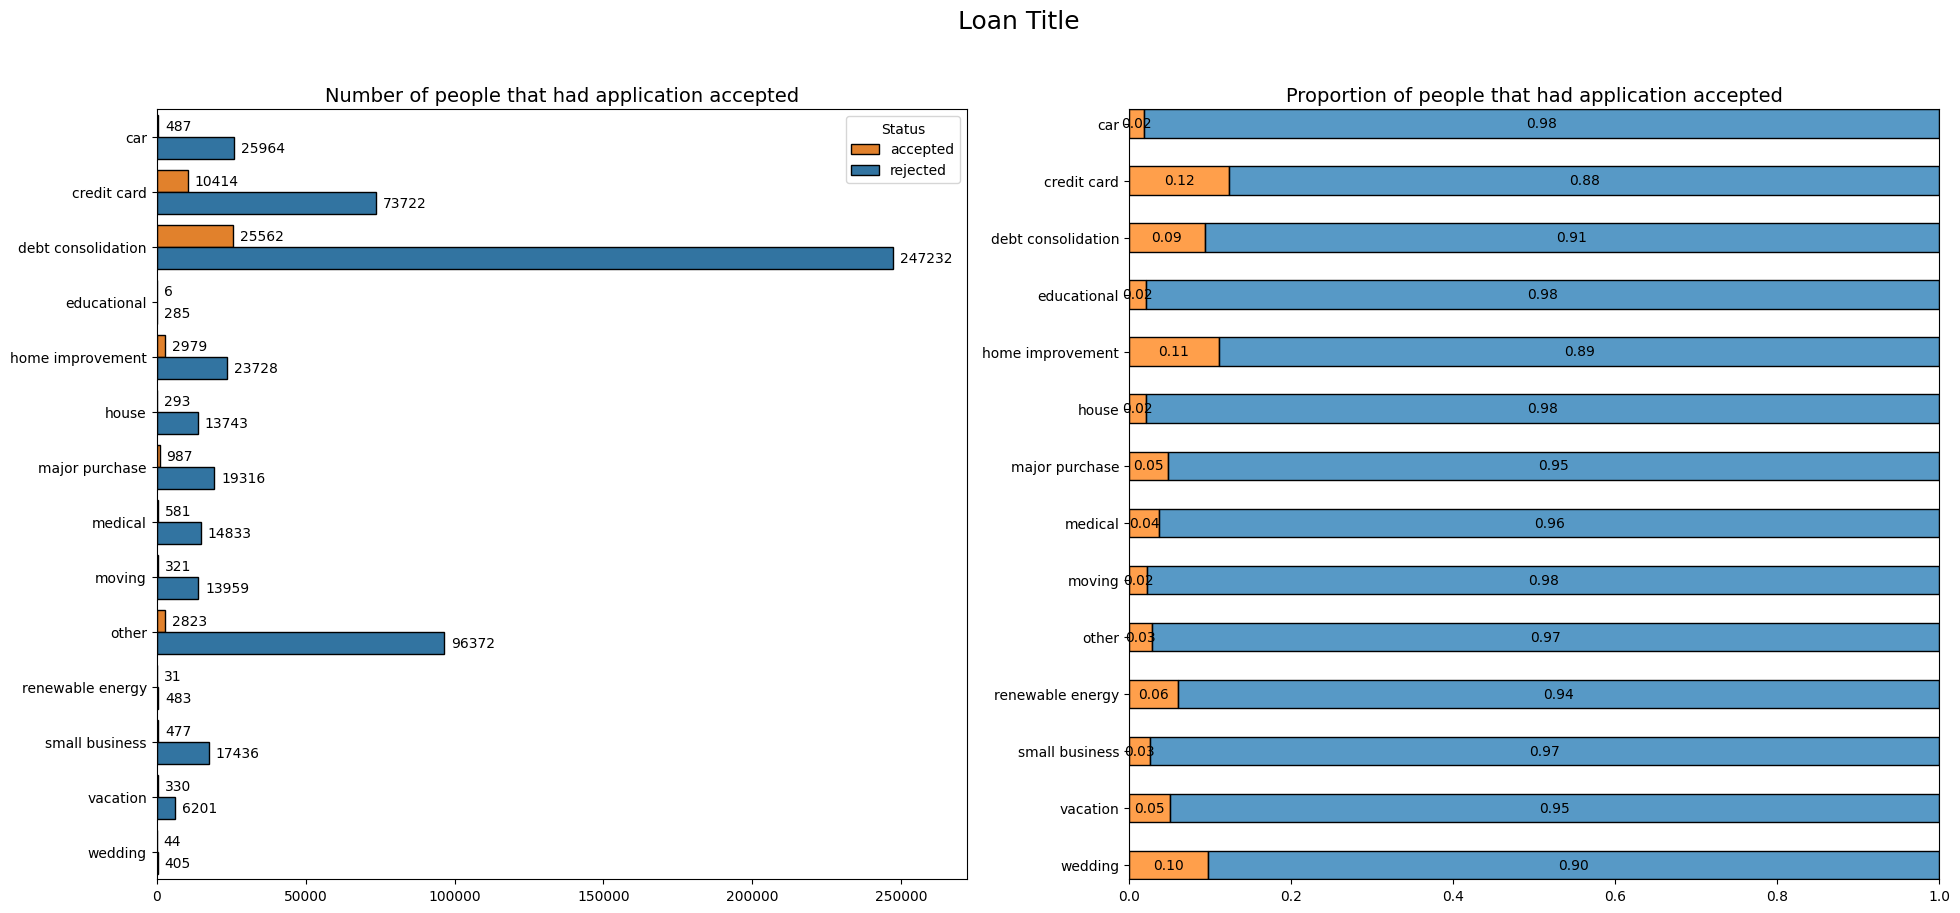

In [ ]:
draw_feature(pdf_subset, 'Loan Title', [23, 10])

The most applications for loan are for debt consolidation, credit card and other reasons. <br>
Loans are the best approved if they are for credit card, home improvement, wedding and debt consolidation reasons. <br>
The least approved loans are for car, educational, small business, moving and medical.

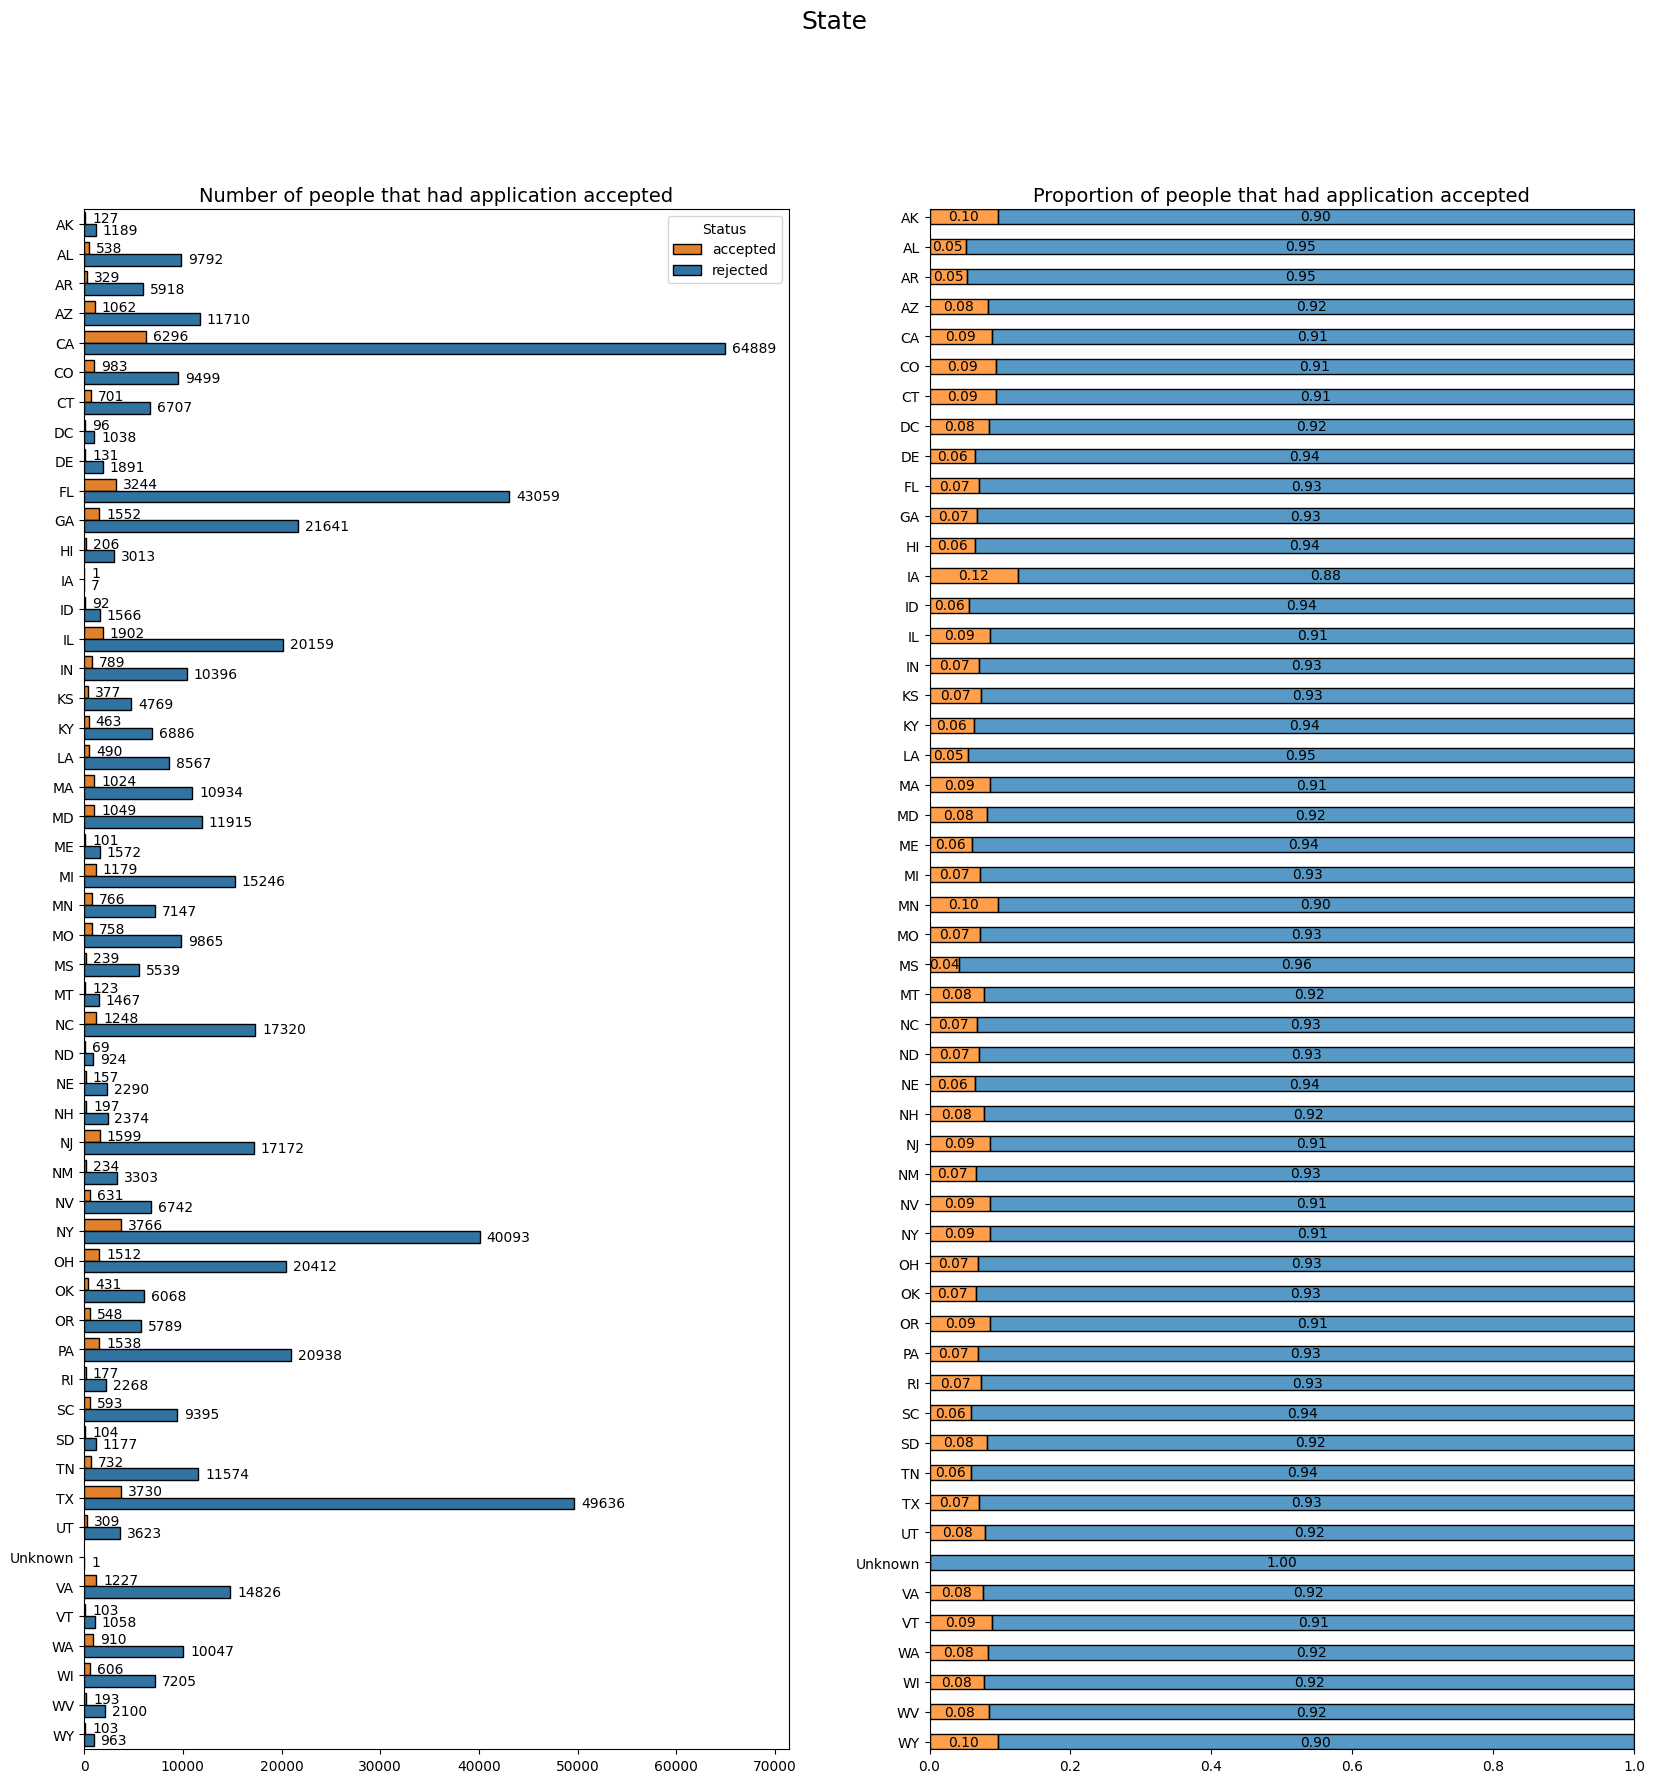

In [ ]:
draw_feature(pdf_subset, 'State', [20, 20])

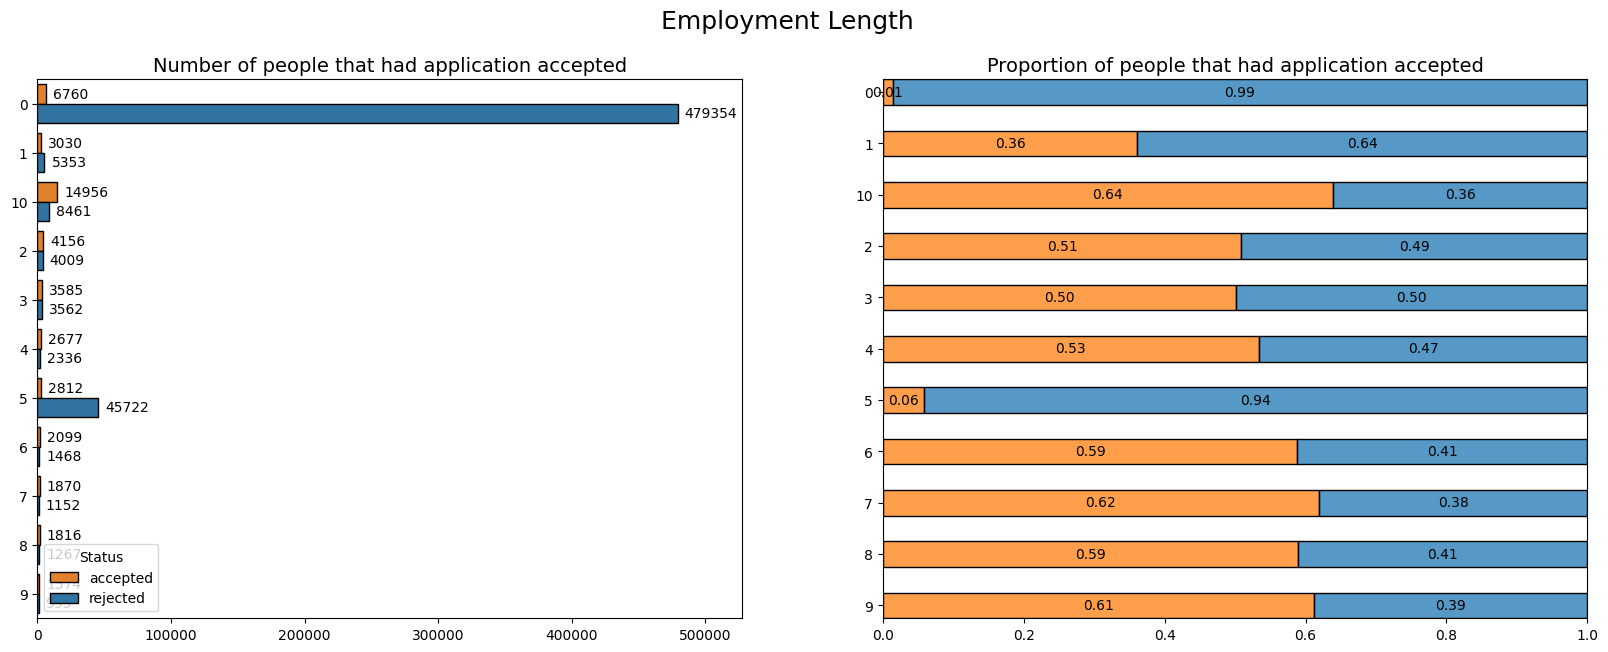

In [ ]:
t = pdf_subset.copy()
t['Employment Length'] = t['Employment Length'].astype(str)
draw_feature(t, 'Employment Length', [20, 7])

There is a trend to give more more loans to people who are employed longer. <br>
Employment length 5 is suspicious, I think it is a mistake in a dataset.

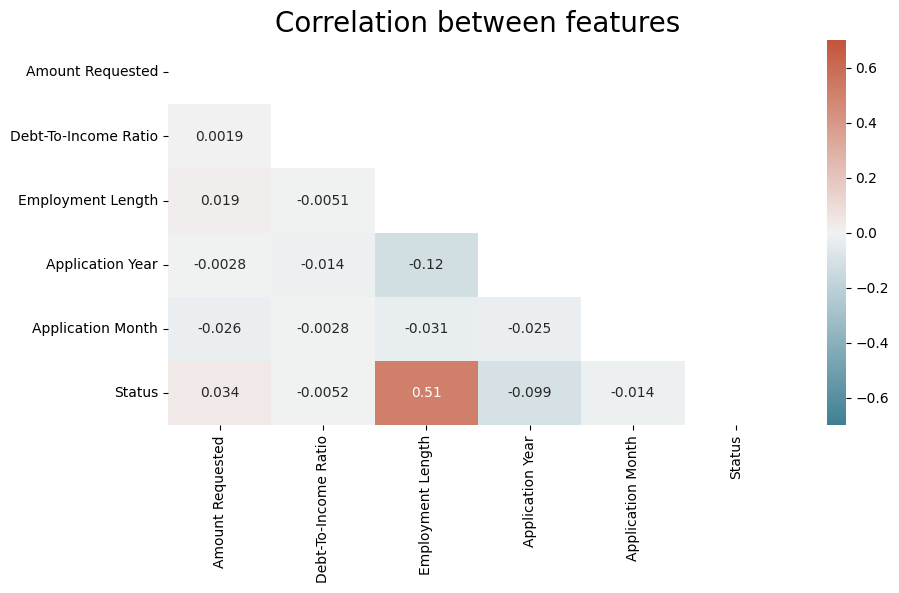

In [ ]:
dictionary = {'accepted': 1, 'rejected': 0}
plt.figure(figsize=(10, 5))
corr = np.round(pdf_subset.replace(dictionary).corr(numeric_only=True), 4)
matrix = np.triu(corr)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask=matrix, cmap=cmap, fmt='.2g', vmin=-0.7,
            vmax=0.7)
plt.title('Correlation between features', fontsize =20)
plt.show()

There is a high correlation between loan status and employment length.

## EDA on loan grade data (approved loans)

### Categoric features

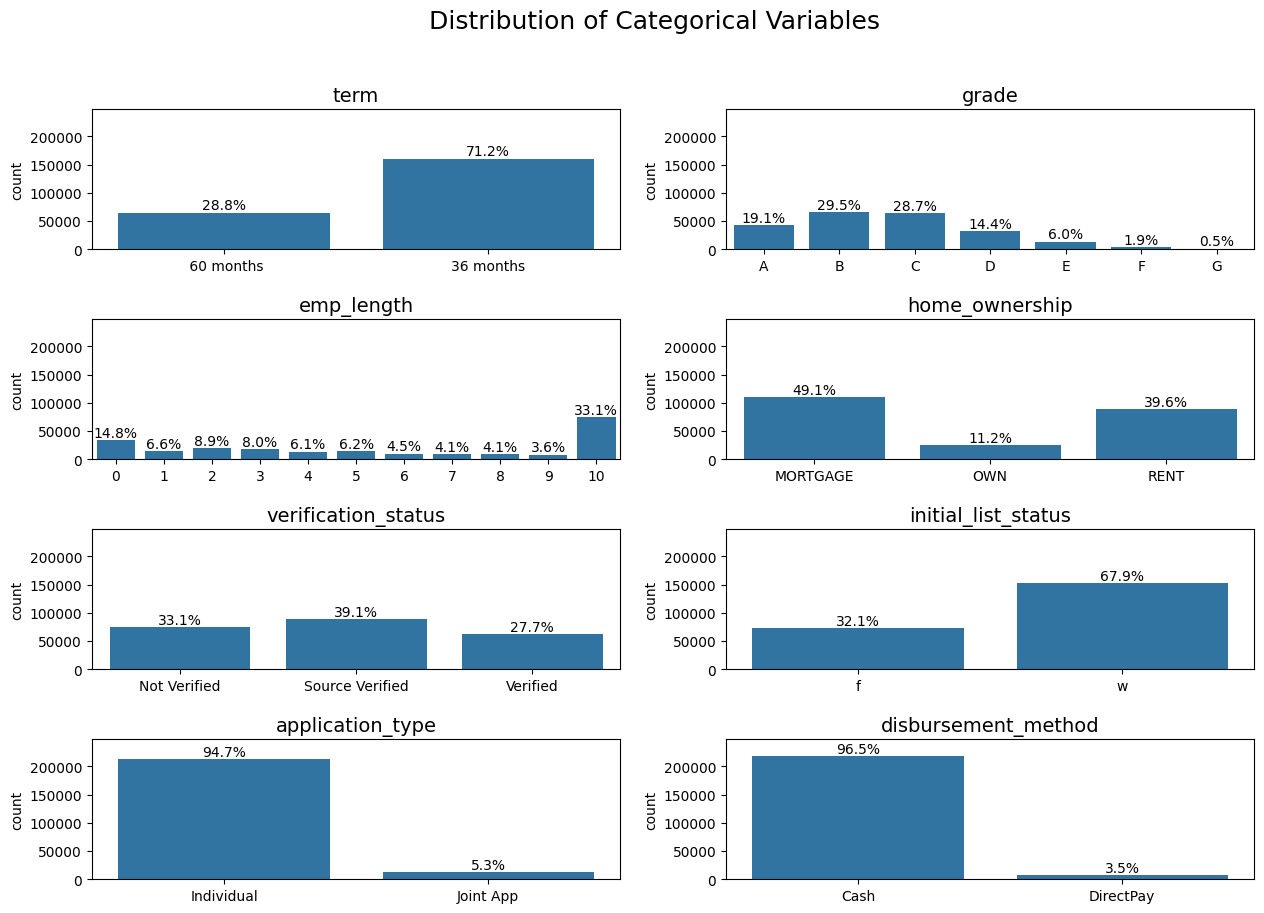

In [ ]:
def plot_distribution_of_cat_variables(df, cat_col, nsize, yaxis_size, figsize):
  fig, axs = plt.subplots(nrows=nsize[0], ncols=nsize[1], 
                          figsize=(figsize[0], figsize[1]),
                        gridspec_kw={'wspace': 0.2, 'hspace': 0.5})
  for i in range(len(cat_col)):
      sns.countplot(x=cat_col[i], data=df.sort_values(by=cat_col[i]), 
                    ax=axs.flatten()[i], color=sns.color_palette()[0])
      axs.flatten()[i].set_title(cat_col[i], fontsize=14)
      total = len(df[cat_col[i]])
      for p in axs.flatten()[i].patches:
          percentage = f'{p.get_height()/total:.1%}'
          axs.flatten()[i].annotate(percentage,
                                    (p.get_x() + p.get_width() / 2, p.get_height()),
                                    ha='center',
                                    va='center',
                                    xytext=(0, 5),
                                    textcoords='offset points')
      max_count = len(df[cat_col[i]])
      axs.flatten()[i].set_ylim(0, max_count*yaxis_size)
  fig.suptitle('Distribution of Categorical Variables', fontsize=18)
  for ax in axs.flat:
      ax.margins(y=0.1)
      ax.set(xlabel=None)
  plt.show()

cat_col = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status',
           'initial_list_status', 'application_type', 'disbursement_method']
plot_distribution_of_cat_variables(df_accepted_subset, cat_col, [4,2], 1.1, [15, 10])

*   Majority of loans are of the grade B and C. Grade F and G loans are pretty rare.
*   Majority of loans are for the period of 36 months, taken individually.
*   Majority of loans takers are having Mortgage, only 10% of them own their home. Majority of them work more than 10 years.
*   Only 3.5% of loan takers pay with using direct pay.


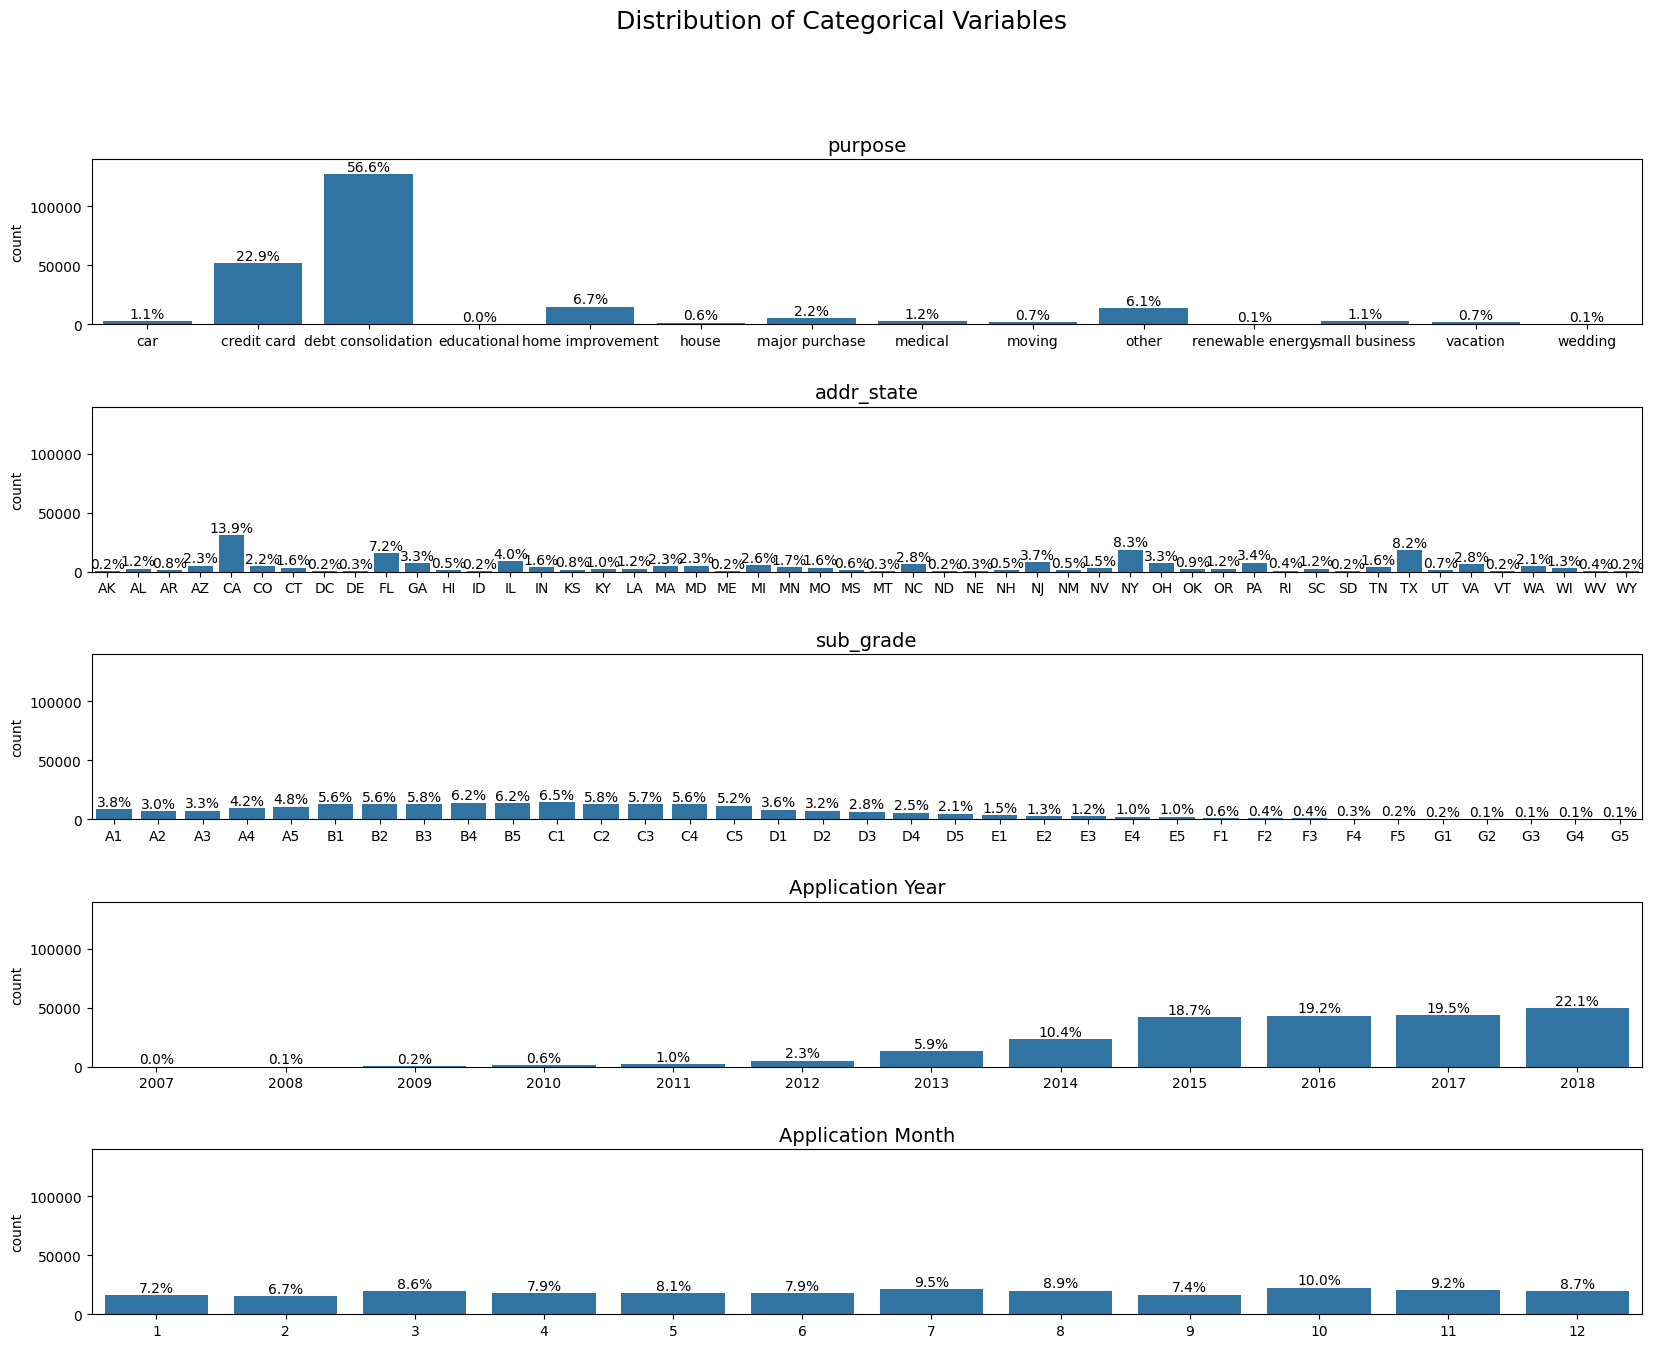

In [ ]:
cat_col=['purpose', 'addr_state', 'sub_grade', 'Application Year', 'Application Month']
plot_distribution_of_cat_variables(df_accepted_subset, cat_col, [5,1], 0.62, [20, 15])

*   The biggest reasons to ask for a loan are:
  * debt consolidation
  * credit card
  * home improvement
*   The number of applications are increasing.
*   Second part of the year is a bit more popular for asking the for the loan.

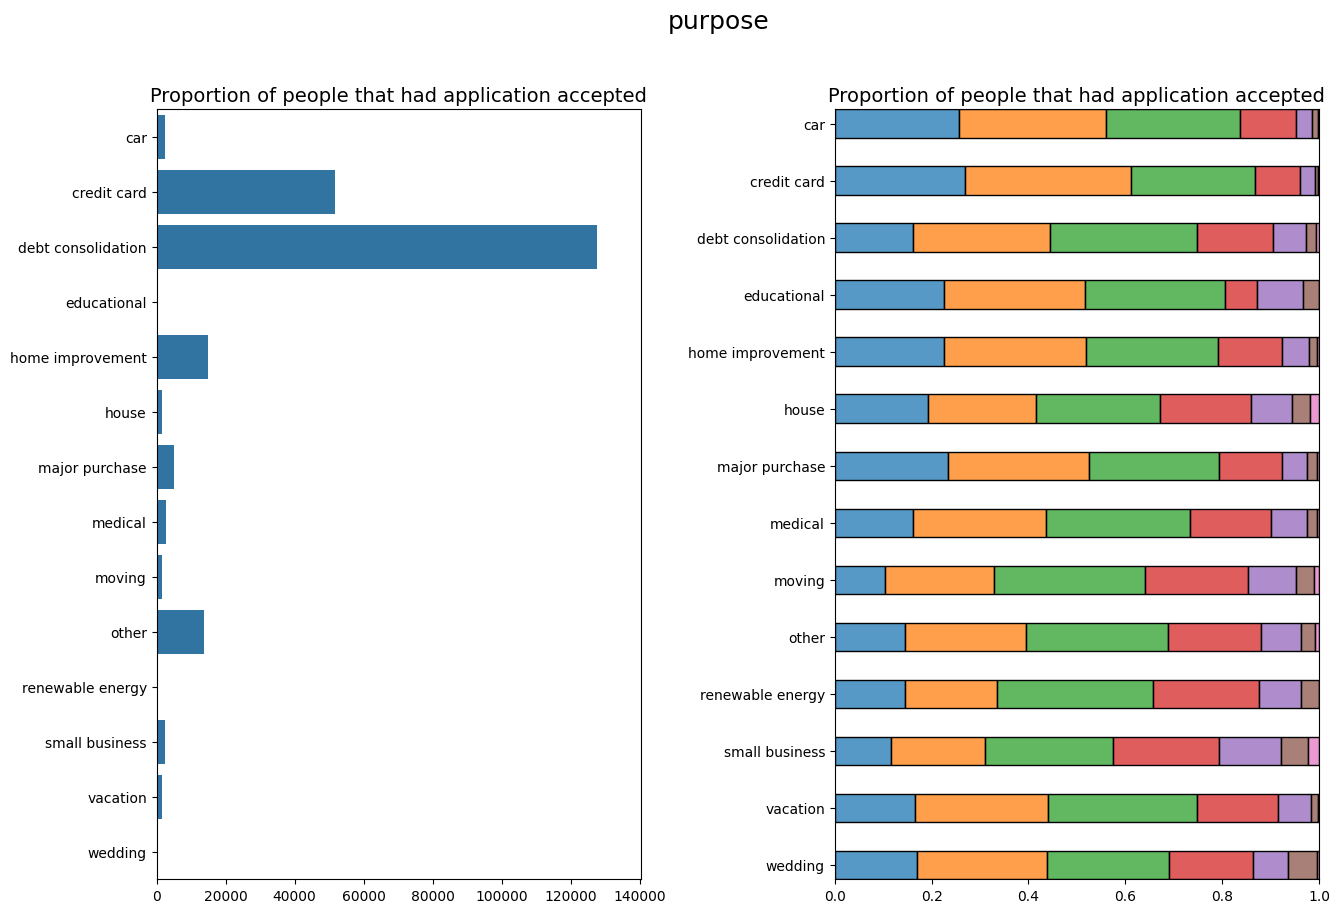

In [ ]:
draw_feature_grade(df_accepted_subset, 'purpose', [15, 10])

Loans with purpose of credit card, car, major purchase, educational and home improvement have better grade on average.

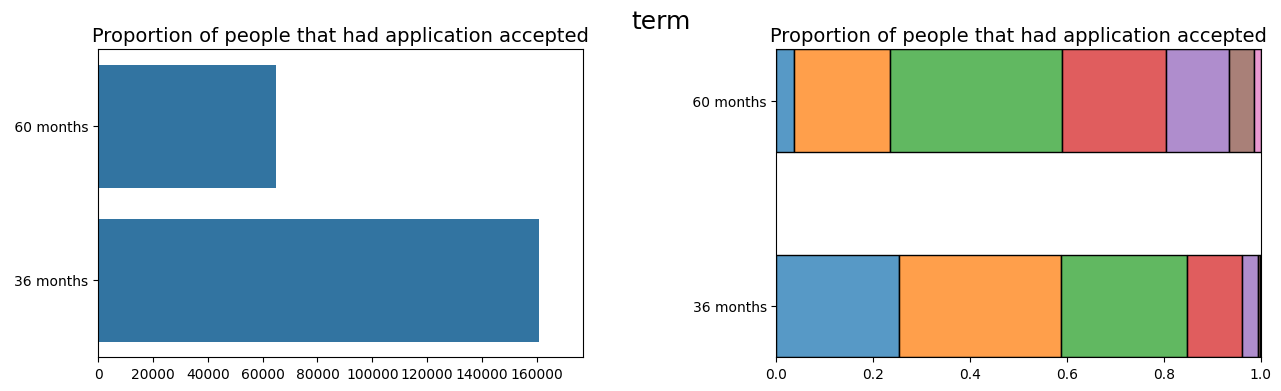

In [ ]:
draw_feature_grade(df_accepted_subset, 'term', [15, 4])

Loans with term of 36 months have way better grades.

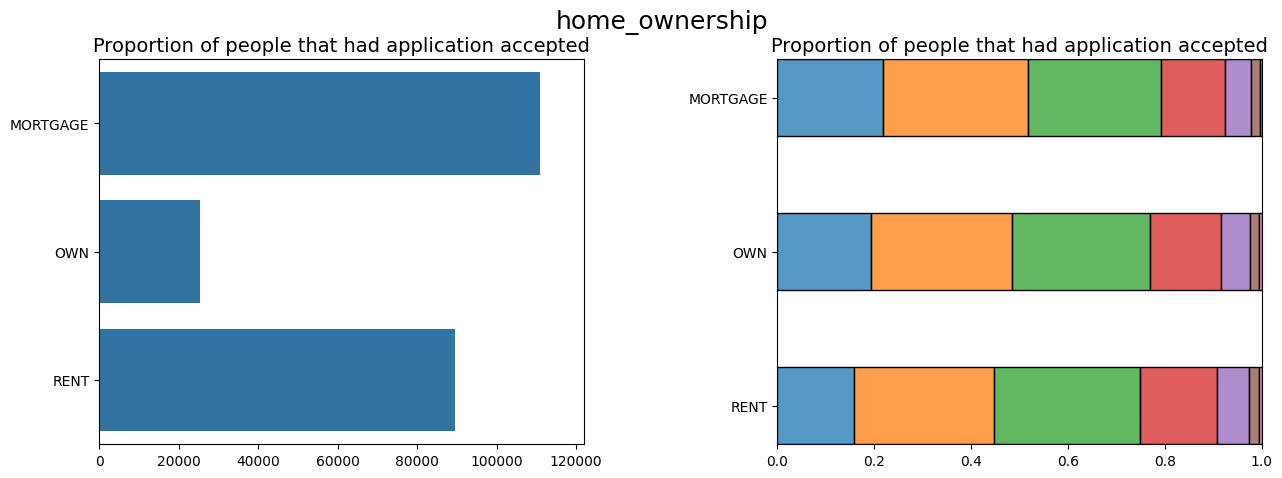

In [ ]:
draw_feature_grade(df_accepted_subset, 'home_ownership', [15, 5])

People who have mortgage have very slightly better grades than the ones who rent. 

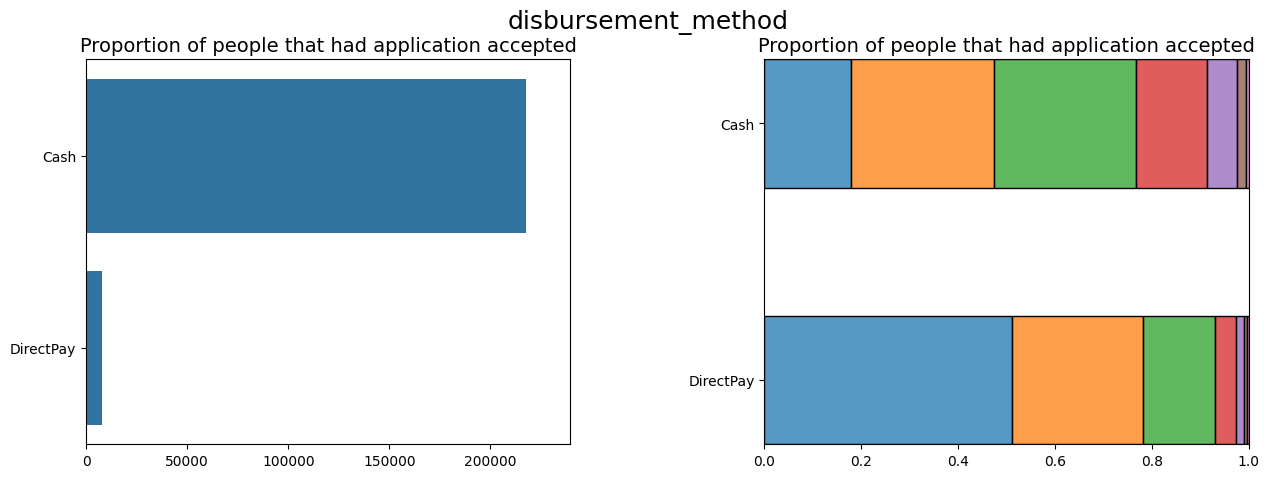

In [ ]:
draw_feature_grade(df_accepted_subset, 'disbursement_method', [15, 5])

Loans where people paying directly have way higher grade values than paying in cash.

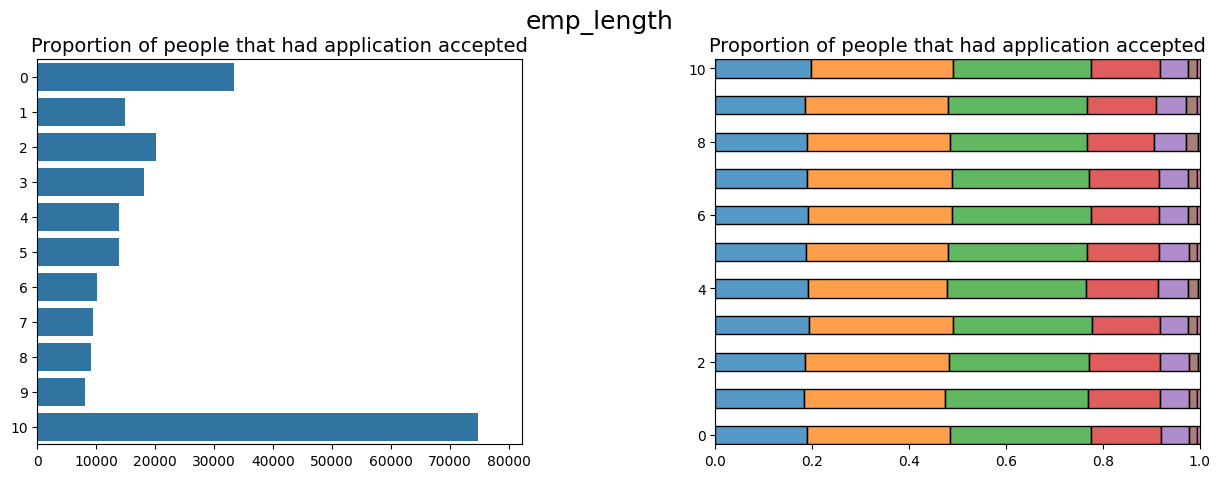

In [ ]:
draw_feature_grade(df_accepted_subset, 'emp_length', [15, 5])

The grades of loan applications show similarity across individuals with different lengths of employment

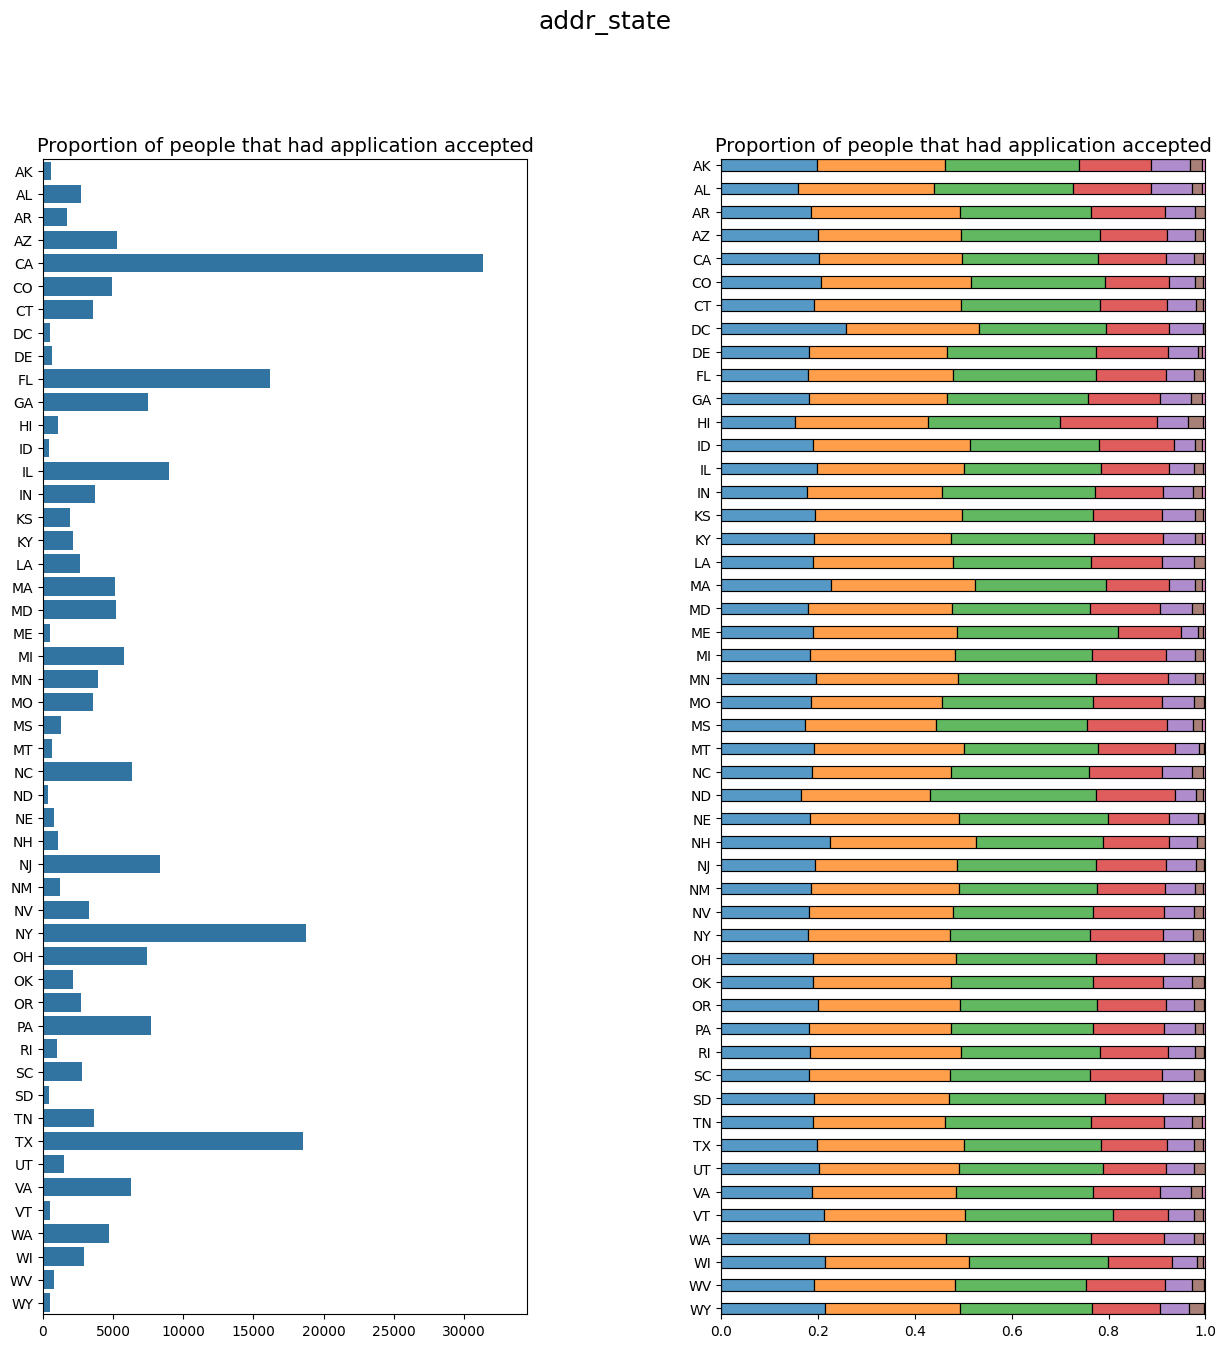

In [ ]:
draw_feature_grade(df_accepted_subset, 'addr_state', [15, 15])

Which of the categorical features are could be used in the model?

Let's perform χ2 test to see if there is a relationship between grade and categorical features. <br>
χ2 test of Independence is used to decide whether there is a relationship exists between two variables of a population.

<b>Parameter of Interest</b>: The relationship between grade and another categorical feature. <br>
<b>Null hypothesis</b>: There is no significant association between these two features.<br>
<b>Alternative hypothesis</b>: There is a significant association between these two features. <br>
<b>Significance level</b>: 0.05


In [ ]:
features = ['verification_status', 'term', 'disbursement_method', 
        'debt_settlement_flag', 'initial_list_status', 'application_type', 
        'home_ownership', 'purpose', 'emp_length', 'addr_state']
for feature in features:
  t = df_accepted_subset.copy()
  cont_table = pd.crosstab(t[feature], t['grade'])
  _, p_val, _, _ = chi2_contingency(cont_table)
  print('Feature:', feature)
  if float(p_val)<0.05:
    print('p-value is', p_val, '< 0.05. This feature could be helpful to predict the grade.')
  else:
    print('p-value is', p_val, '> 0.05. This feature would not be helpful to predict the grade.')
  print()

Feature: verification_status
p-value is 0.0 < 0.05. This feature could be helpful to predict the grade.

Feature: term
p-value is 0.0 < 0.05. This feature could be helpful to predict the grade.

Feature: disbursement_method
p-value is 0.0 < 0.05. This feature could be helpful to predict the grade.

Feature: debt_settlement_flag
p-value is 4.767043695048129e-185 < 0.05. This feature could be helpful to predict the grade.

Feature: initial_list_status
p-value is 0.0 < 0.05. This feature could be helpful to predict the grade.

Feature: application_type
p-value is 7.503753951673816e-17 < 0.05. This feature could be helpful to predict the grade.

Feature: home_ownership
p-value is 8.805883201774e-312 < 0.05. This feature could be helpful to predict the grade.

Feature: purpose
p-value is 0.0 < 0.05. This feature could be helpful to predict the grade.

Feature: emp_length
p-value is 4.9641085587379755e-05 < 0.05. This feature could be helpful to predict the grade.

Feature: addr_state
p-valu

### Numeric features

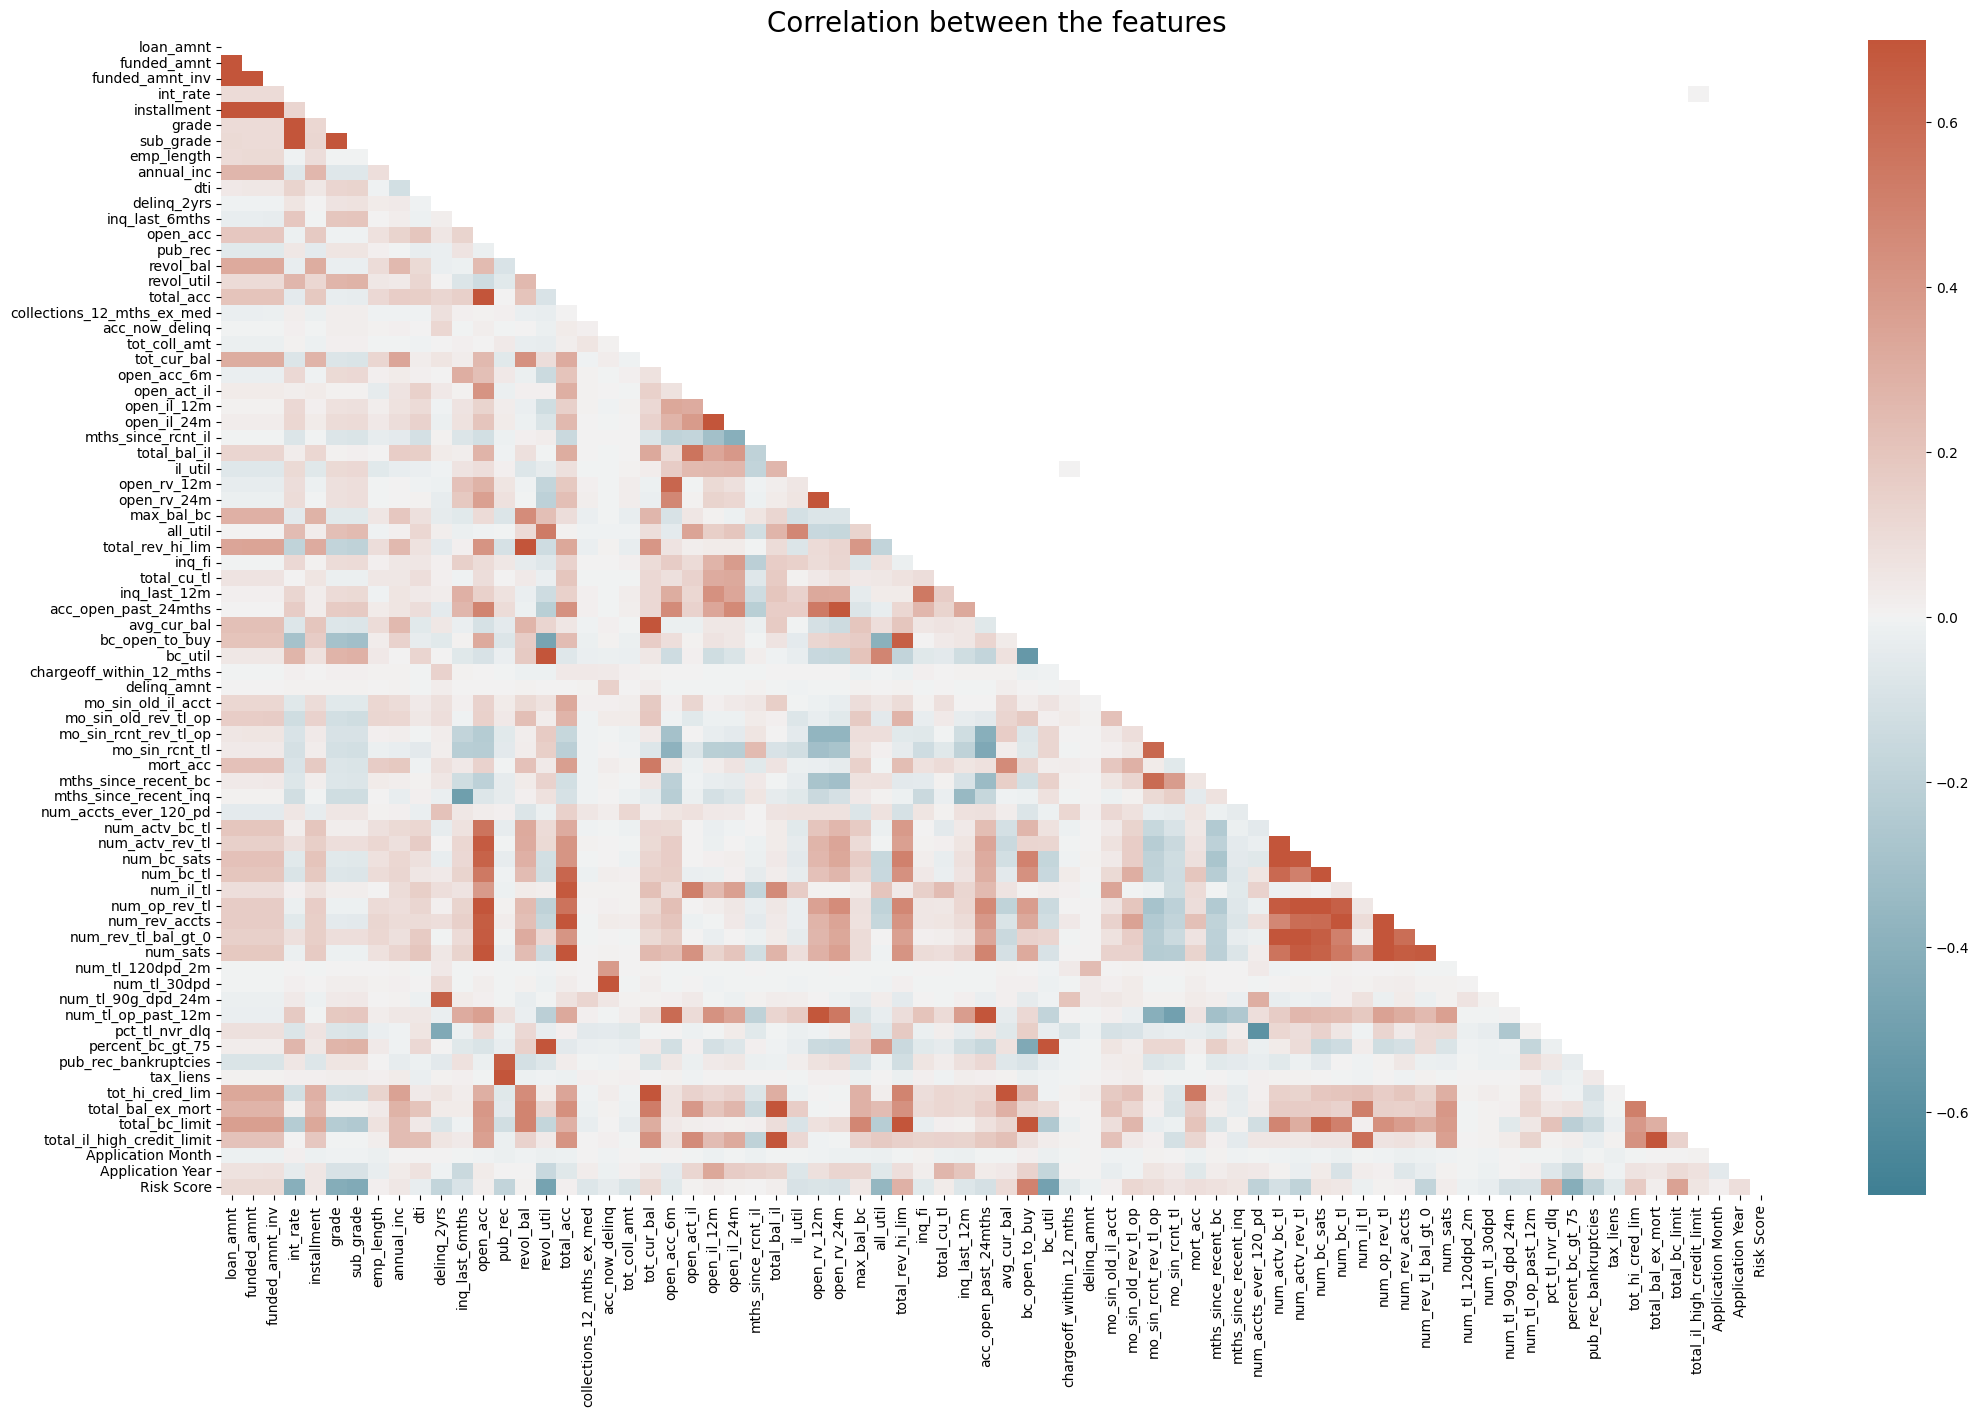

In [ ]:
d1 = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G':7}
d2 = {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5, 'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 
      'B5': 10, 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15, 'D1': 16, 'D2': 17, 
      'D3': 18, 'D4': 19, 'D5': 20, 'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25, 
      'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30, 'G1': 31, 'G2': 32, 'G3': 33, 
      'G4': 34, 'G5': 35}
plt.figure(figsize=(25, 15))
corr = np.round(df_accepted_subset.replace(d1).replace(d2).corr(numeric_only=True), 4)
matrix = np.triu(corr)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, annot=False, mask=matrix, cmap=cmap, fmt='.1g', vmin=-0.7,
            vmax=0.7)
plt.title('Correlation between the features', fontsize=20)
plt.show()

Features having the highest correlation with loan grade:

In [ ]:
t = np.round(df_accepted_subset.replace(dictionary).replace(d1)/
             .corr(numeric_only=True), 2)[['grade']]
t.sort_values(by='grade', ascending=True).head(10).style.format(precision=2)/
    .background_gradient(cmap='PuBu_r', vmin=-1, vmax=0)

,grade
Risk Score,-0.42
bc_open_to_buy,-0.29
total_bc_limit,-0.23
total_rev_hi_lim,-0.19
mths_since_recent_inq,-0.13
tot_hi_cred_lim,-0.12
mo_sin_old_rev_tl_op,-0.12
mo_sin_rcnt_tl,-0.11
mo_sin_rcnt_rev_tl_op,-0.09
Application Year,-0.09


In [ ]:
t.sort_values(by='grade', ascending=True).tail(10).style.format(precision=2)/
    .background_gradient(cmap='PuBu', vmin=0, vmax=1)

,grade
dti,0.13
acc_open_past_24mths,0.17
num_tl_op_past_12m,0.18
inq_last_6mths,0.19
all_util,0.23
percent_bc_gt_75,0.27
revol_util,0.27
bc_util,0.28
int_rate,0.95
grade,1.00


Selecting the most important numeric features

In [ ]:
numeric_cols = df_accepted_subset.select_dtypes(include=['int', 'float']).columns.tolist()
t = df_accepted_subset[numeric_cols]
X = t.loc[:, ~t.columns.isin(['grade', 'sub_grade', 'int_rate'])]
y = df_accepted_subset['grade'].replace(d1)

fvalue_Best = SelectKBest(f_classif, k=15)
X_kbest = fvalue_Best.fit_transform(X, y)

selected_feature_indices = fvalue_Best.get_support(indices=True)
selected_feature_names = [X.columns[idx] for idx in selected_feature_indices]

print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_kbest.shape[1])

Original number of features: 71
Reduced number of features: 15


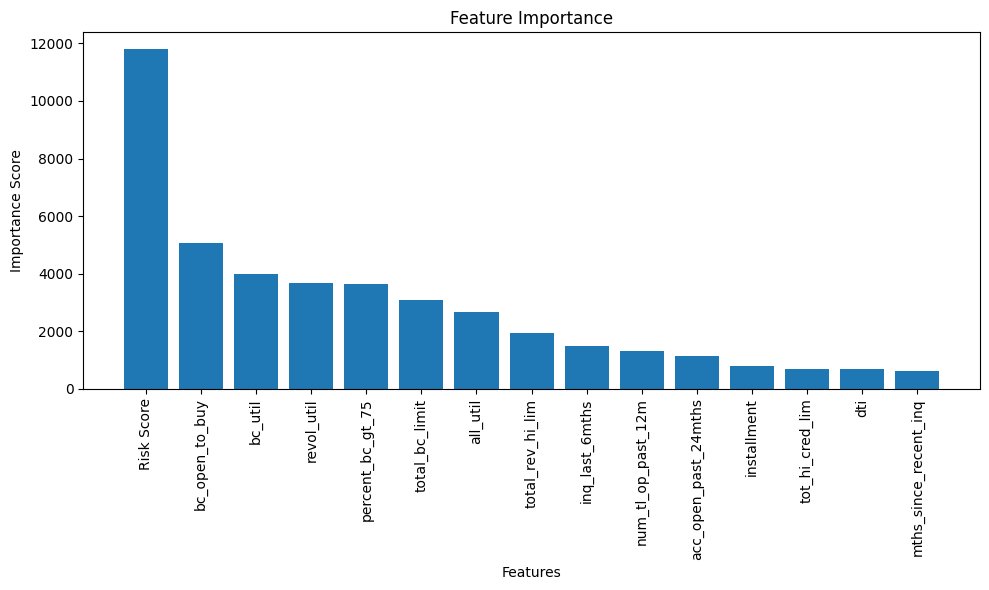

In [ ]:
feature_scores = fvalue_Best.scores_
sorted_features = sorted(zip(selected_feature_names, feature_scores[selected_feature_indices]), 
                         key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_feature_scores = zip(*sorted_features)

plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_feature_scores, color=sns.color_palette()[0])
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Meaning of the features:    

**Risk Score**: the loan's level of risk. <br>
**bc_open_to_buy**: Available credit on revolving bankcards.<br>
**bc_util**: Ratio of current balance to credit limit on bankcard accounts.<br>
**revol_util**: Revolving credit utilization rate.<br>
**percent_bc_gt_75**: Percentage of bankcard accounts with utilization over 75%.<br>
**total_bc_limit**: Total credit limit on bankcard accounts.<br>
**all_util**: Balance to credit limit ratio on all trades.<br>
**total_rev_hi_lim**: Total credit limit on revolving accounts.<br>
**inq_last_6mths**: Number of credit inquiries in the last 6 months.<br>
**num_tl_op_past_12m**: Number of trades opened in the past 12 months.<br>
**acc_open_past_24mths**: Number of trades opened in the past 24 months.<br>
**installment**: Monthly payment amount for the loan.<br>
**tot_hi_cred_lim**: Total high credit or credit limit across all accounts.<br>
**dti**: Debt-to-income ratio.<br>
**mths_since_recent_inq**: Months since the most recent credit inquiry.

The distribution of key numerical features with respect to loan grades:

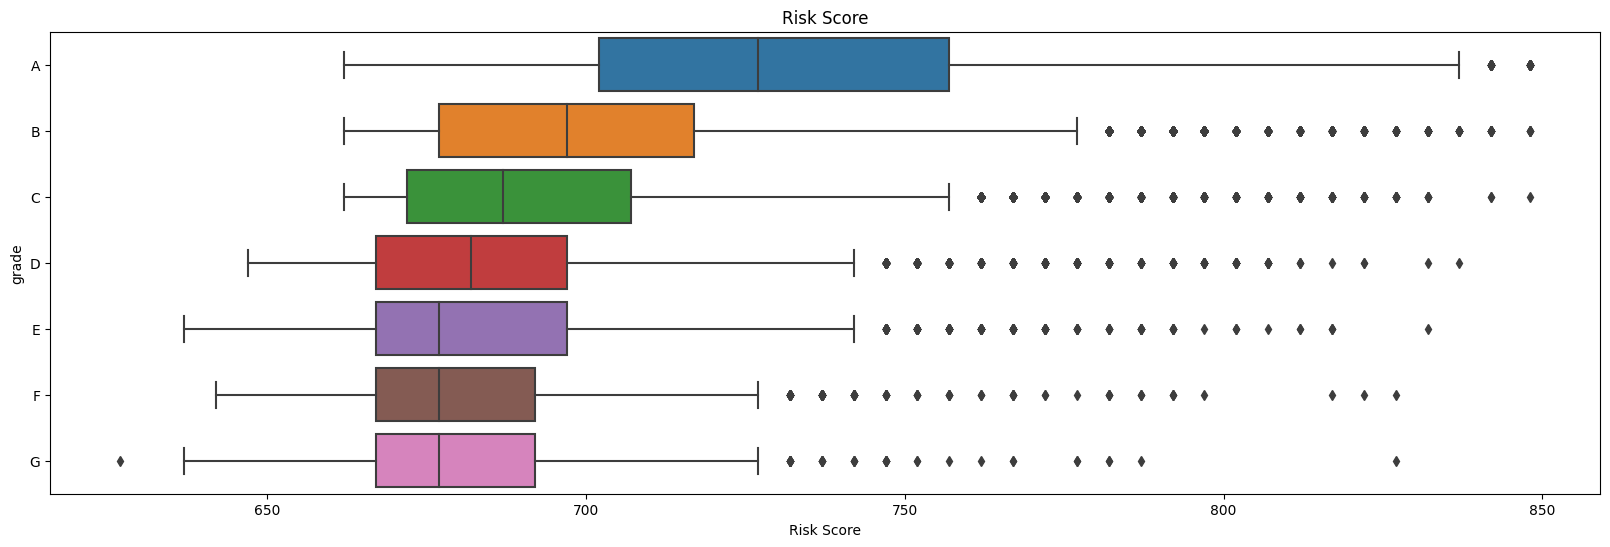

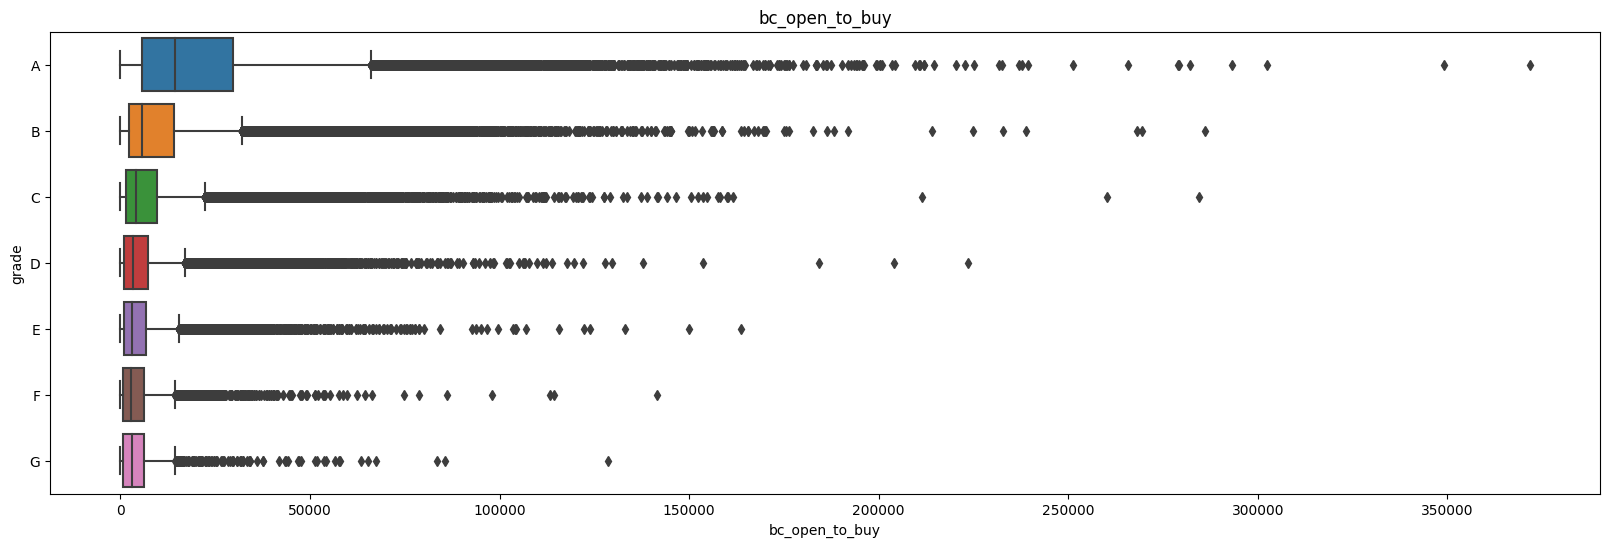

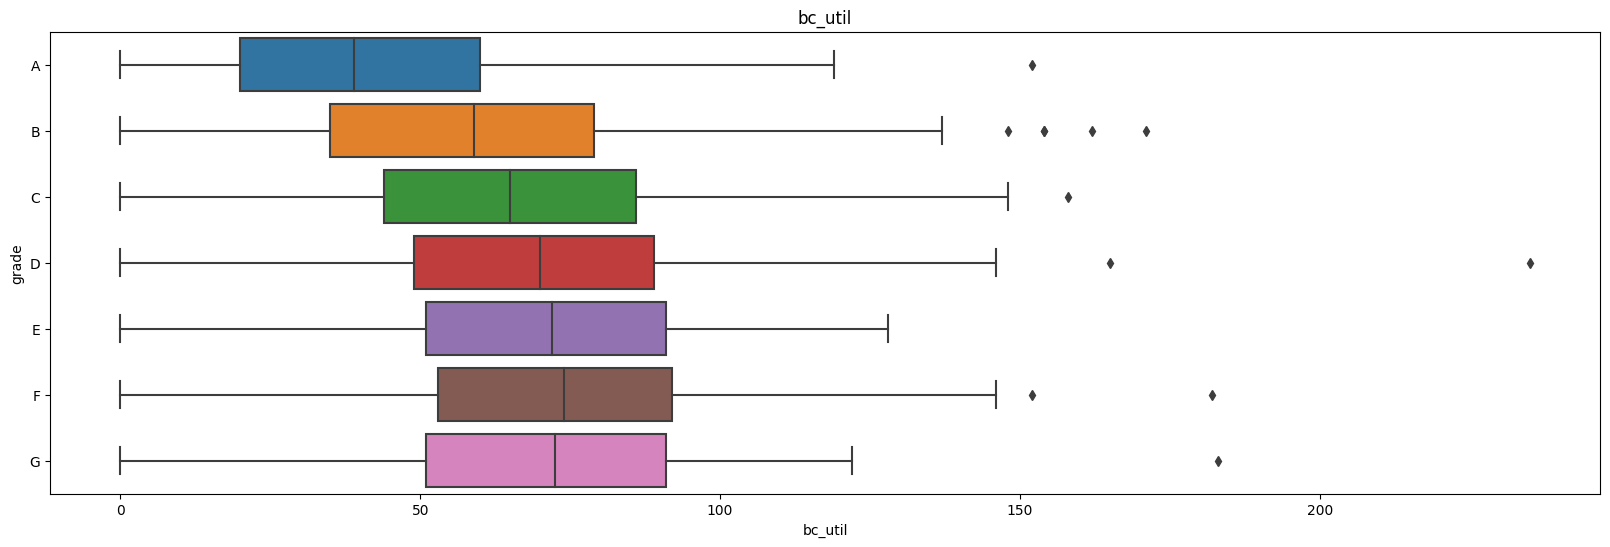

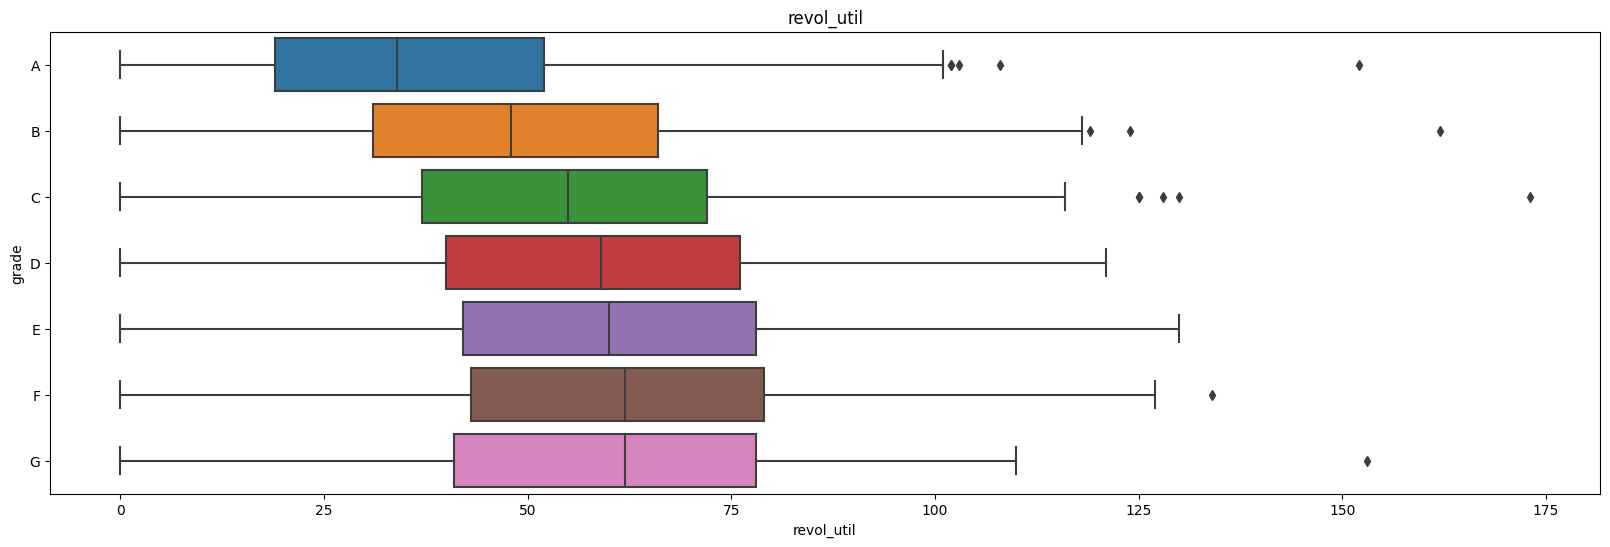

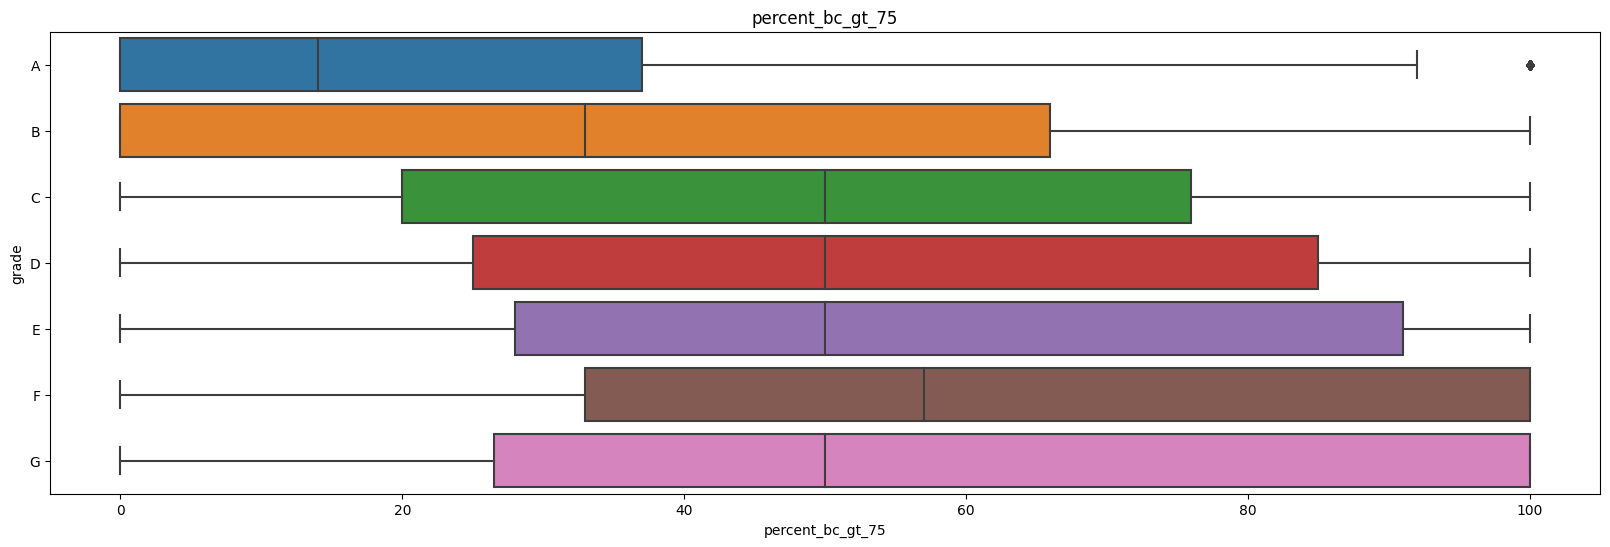

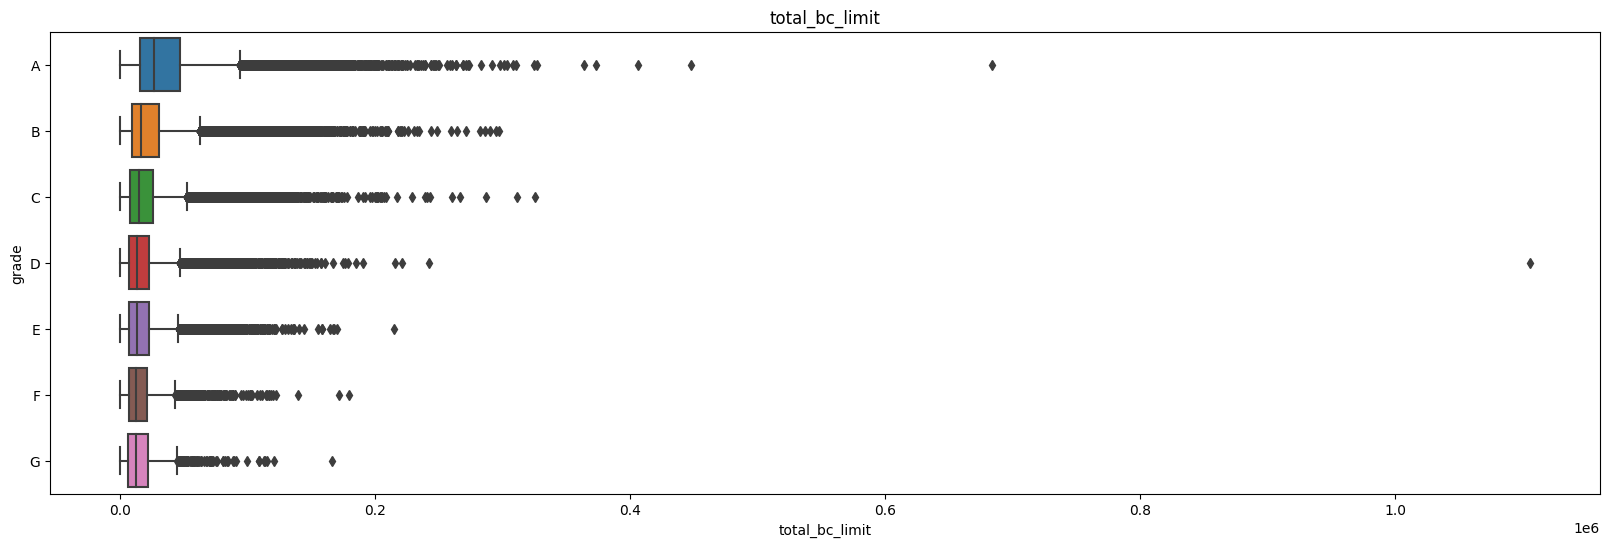

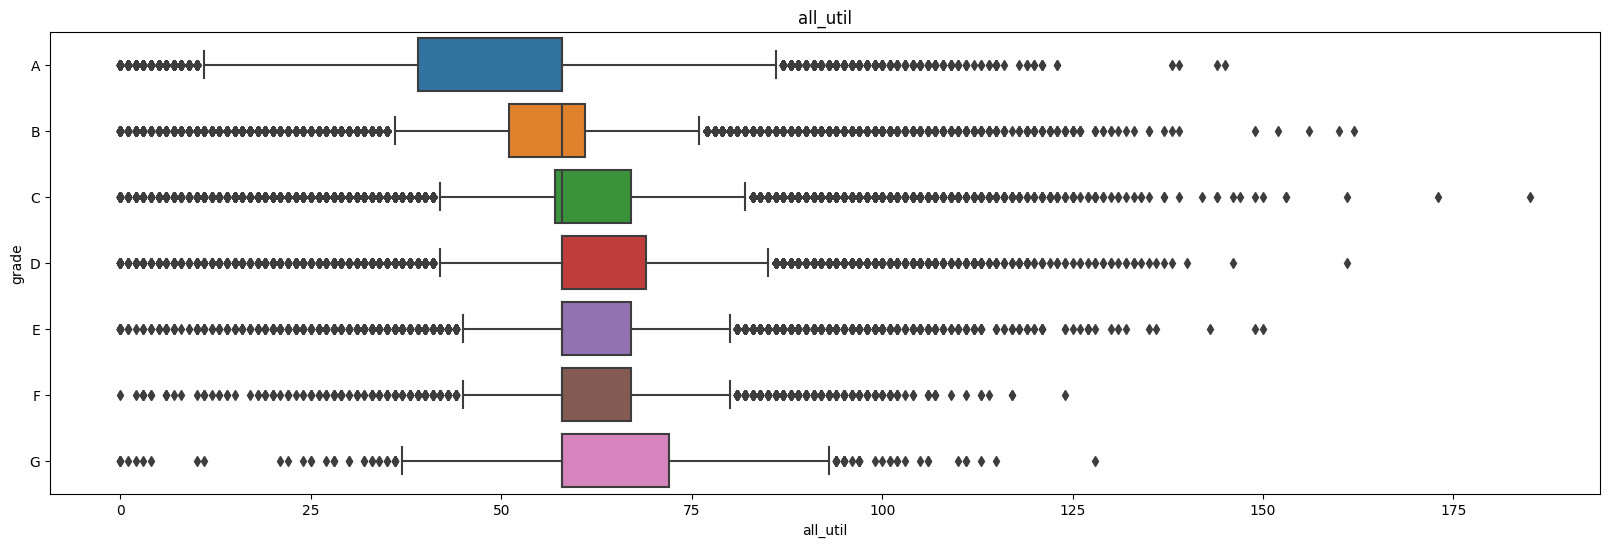

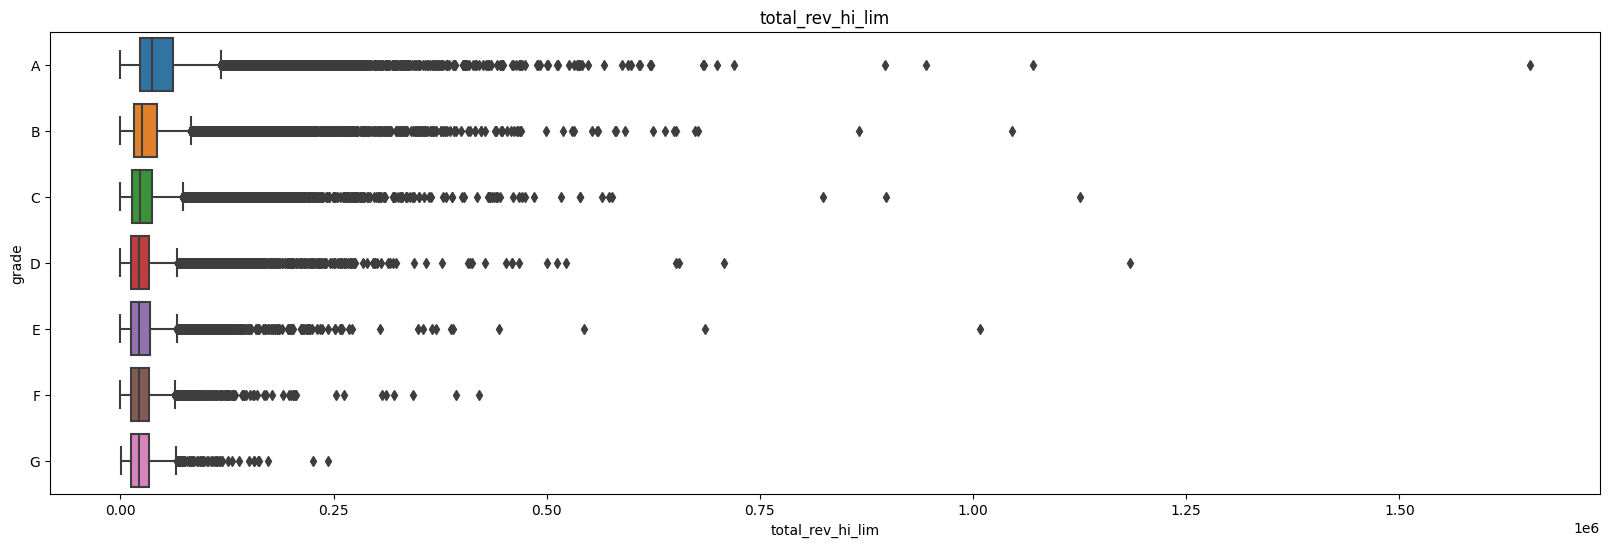

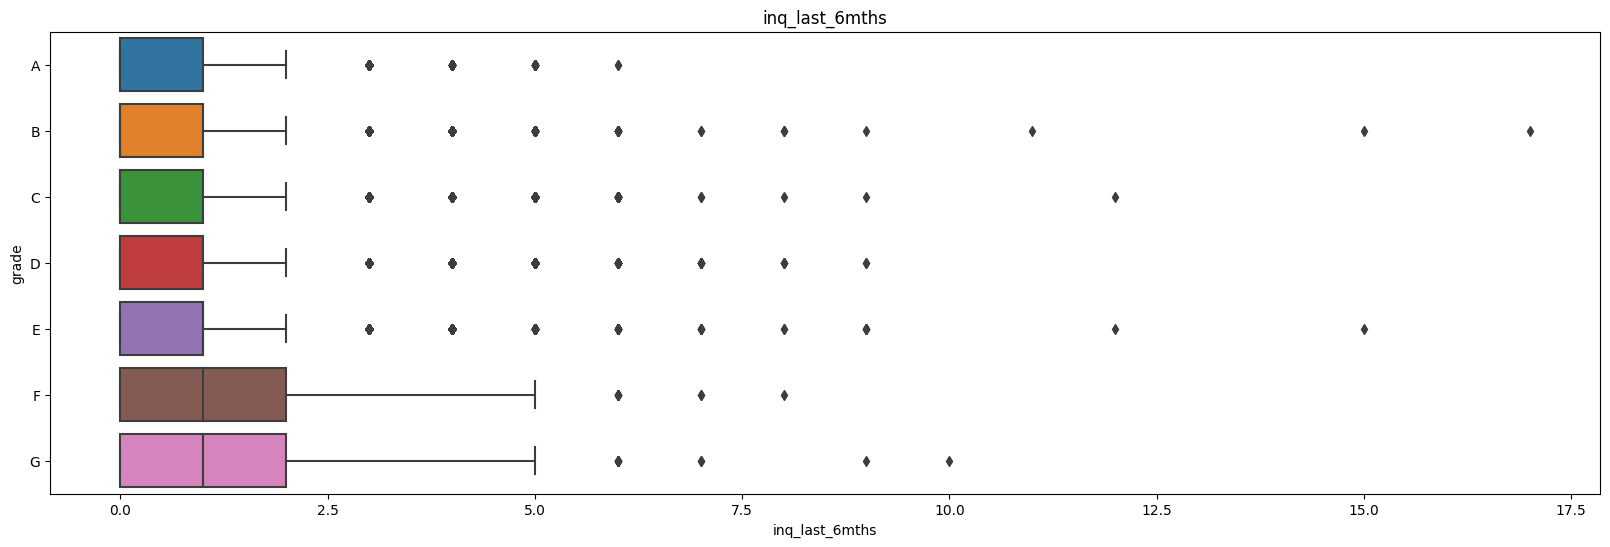

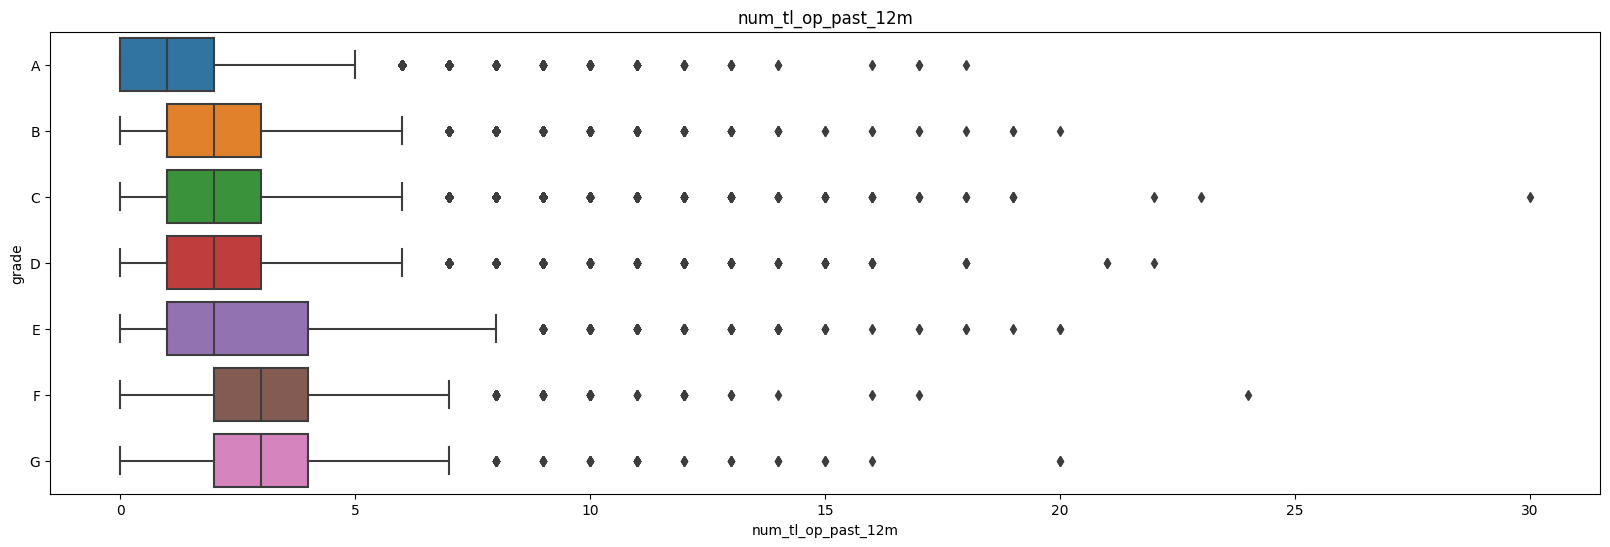

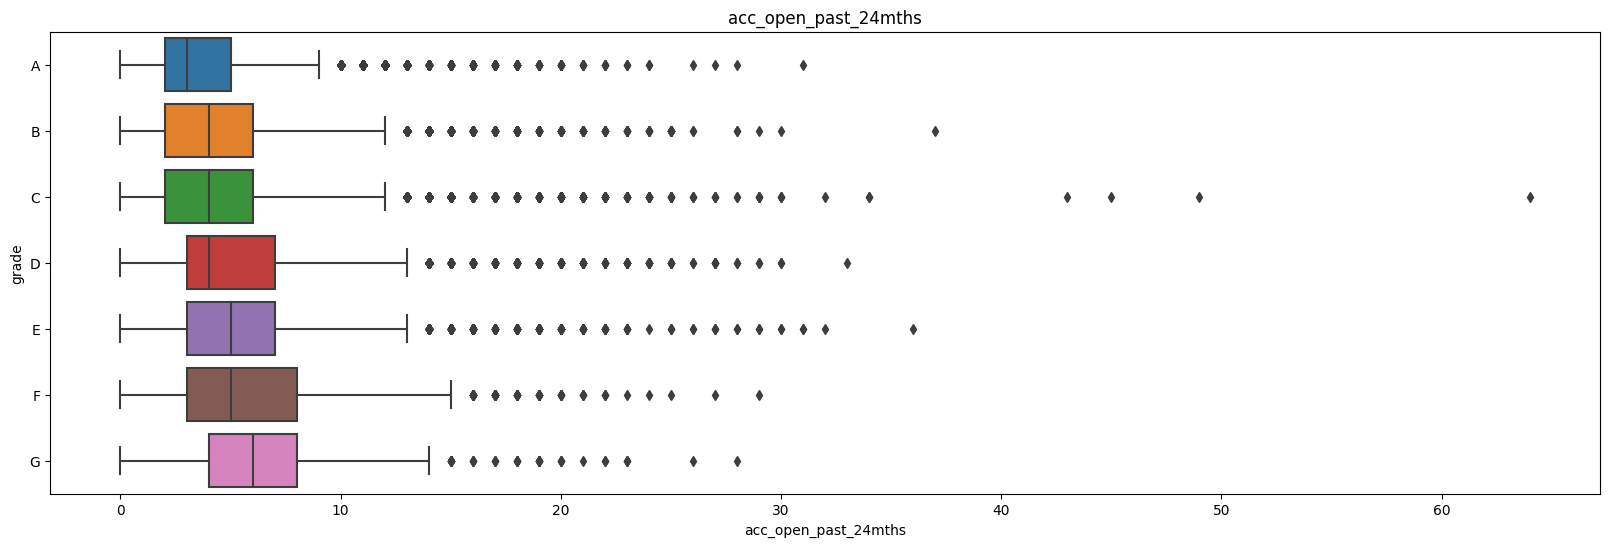

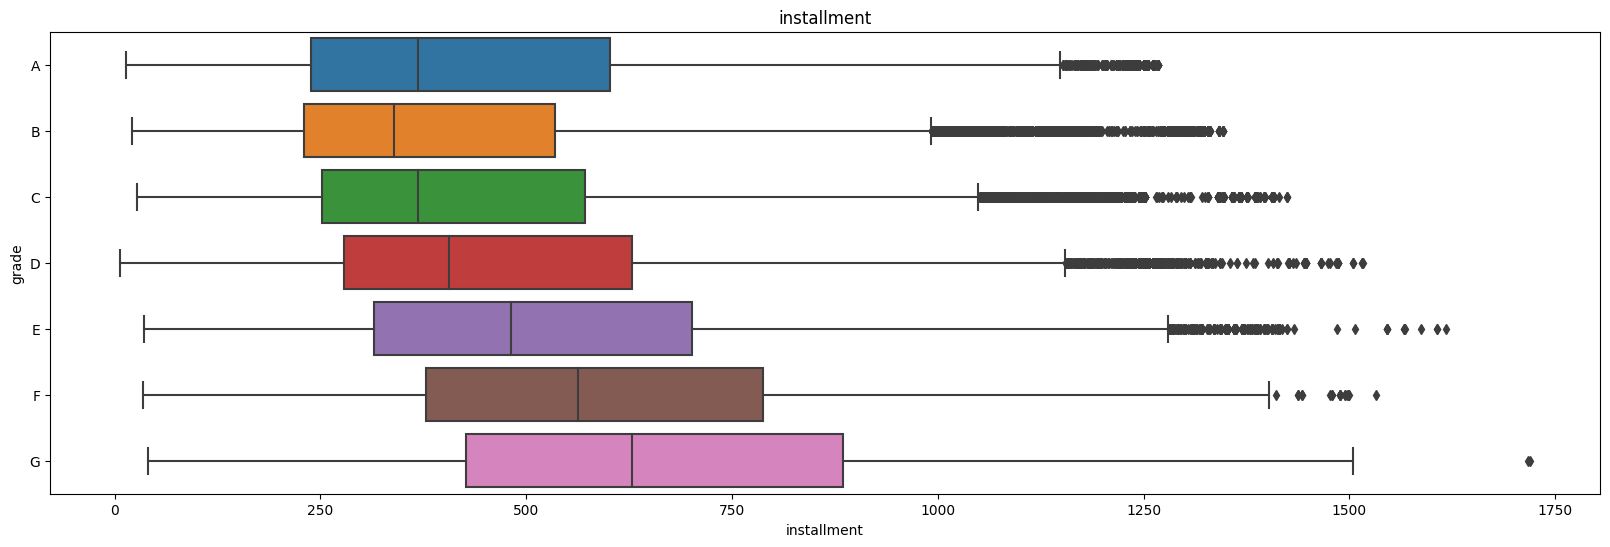

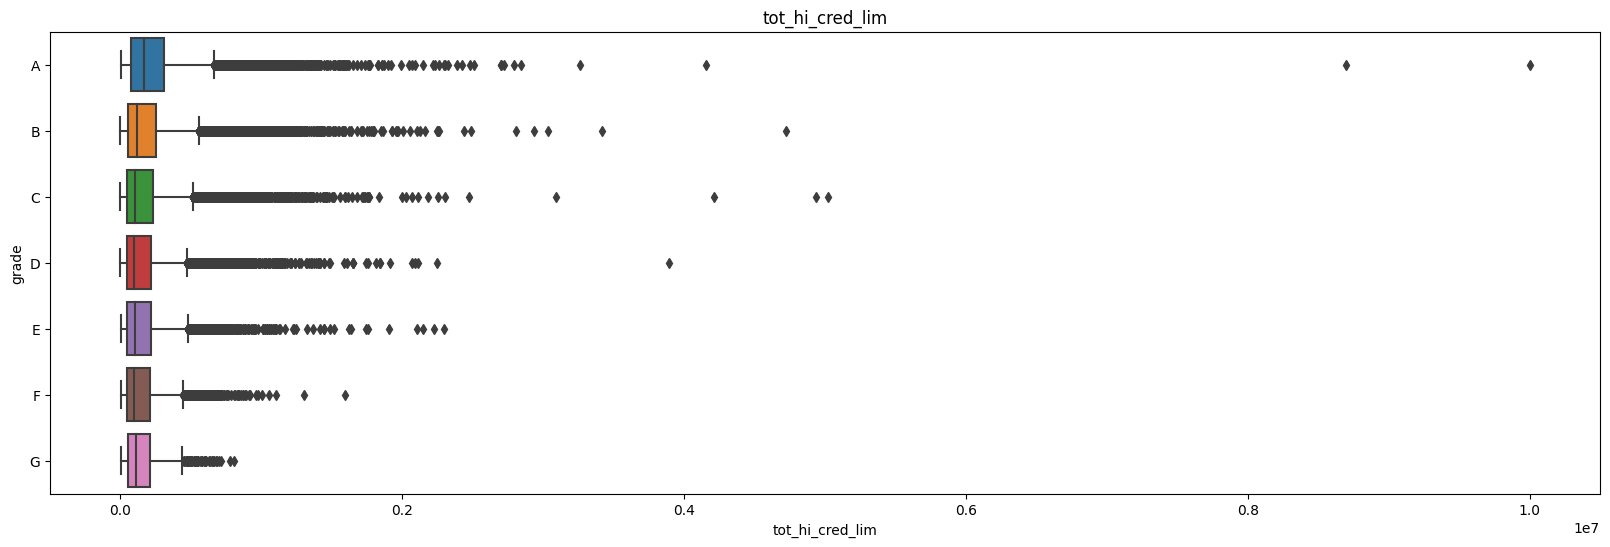

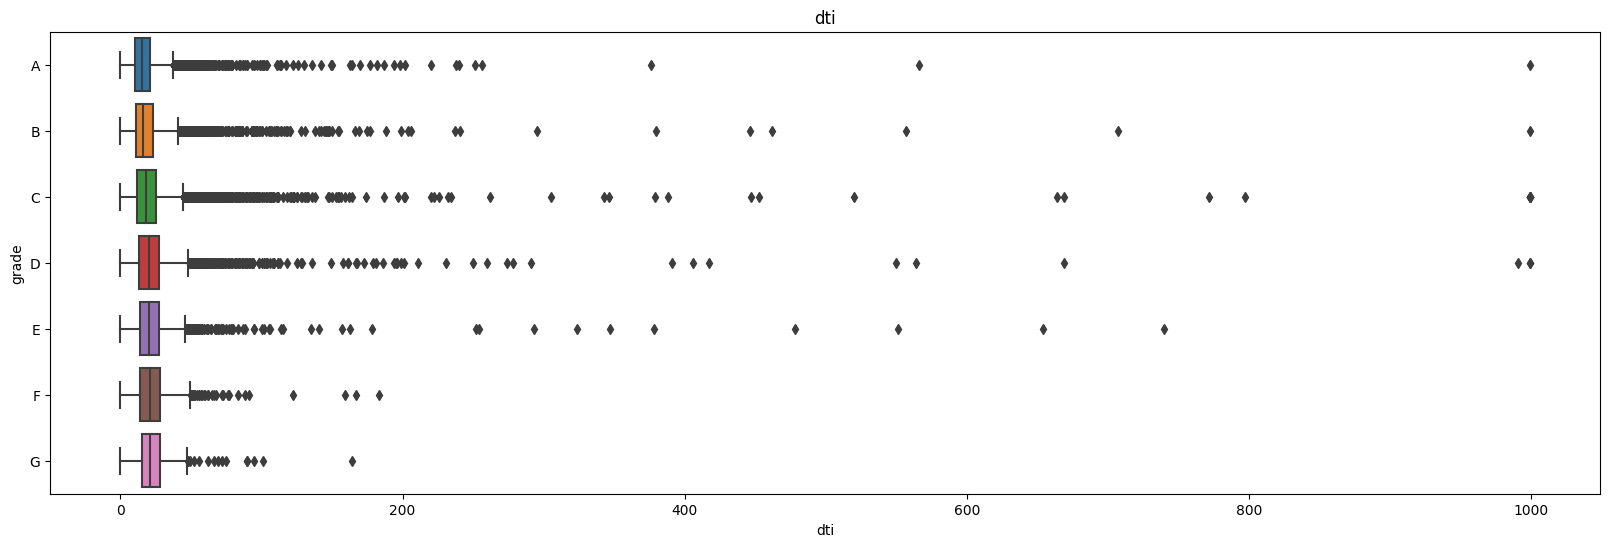

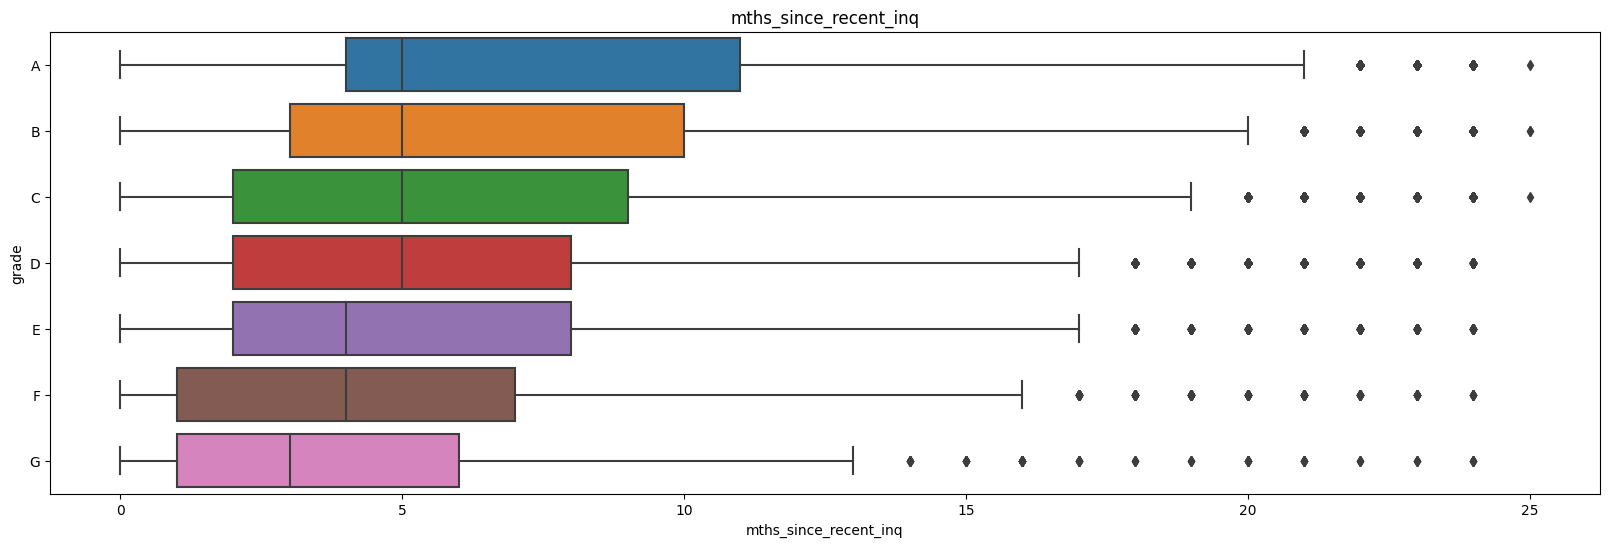

In [ ]:
for col in sorted_feature_names:
  plt.figure(figsize=(20, 6))
  sns.boxplot(y='grade', x=col, data=df_accepted_subset.sort_values('grade'))
  plt.title(col)
  plt.show()

The distributions of loan grades over the selected numerical features vary significantly. Notably, the distributions for lower grade loans show more similarities amongst themselves compared to those of higher grade loans.

# Modeling

Extracting a subset of the data for predicting a loan status (accepted/rejected) prediction

In [ ]:
sdf_status = sdf_status.withColumn('Employment Length', sdf_status['Employment Length'].cast('int'))
sdf_status = sdf_status.withColumn('Status', f.when(sdf_status['Status'] == 'rejected', 0).otherwise(1))

In [ ]:
df_status_1 = sdf_status.filter(f.col('Status') == 1).orderBy(f.rand()).limit(50000)
df_status_0 = sdf_status.filter(f.col('Status') == 0).orderBy(f.rand()).limit(50000)

train_dataset = df_status_1.union(df_status_0)
remaining_dataset = sdf_status.subtract(train_dataset)
test_dataset = remaining_dataset.sample(False, 20000 / remaining_dataset.count(), seed=1)

train_dataset.toPandas().to_pickle('train_dataset_status.pkl')
test_dataset.toPandas().to_pickle('test_dataset_status.pkl')

Extracting a subset of the data for predicting the grade and interest rate

In [ ]:
cols = list(sorted_feature_names) + ['verification_status', 'grade', 'sub_grade', 
                                     'term', 'disbursement_method', 'debt_settlement_flag', 
                                     'initial_list_status', 'application_type', 'home_ownership', 
                                     'purpose', 'emp_length', 'int_rate']

In [ ]:
grade_limits = {'A': 12100, 'B': 12100, 'C': 12100, 'D': 12100, 'E': 12100, 'F': 12100, 'G': 12100}
df_list = [
    sdf_accepted.select(*cols).filter(f.col('grade') == grade).orderBy(f.rand()).limit(limit)
    for grade, limit in grade_limits.items()
]
train_dataset = reduce(lambda df1, df2: df1.unionAll(df2), df_list)
remaining_dataset = sdf_accepted.select(*cols).subtract(train_dataset)

In [ ]:
grade_limits = {'A': 1910, 'B': 2950, 'C': 2870, 'D': 1440, 'E': 600, 'F': 190, 'G': 50}
df_list = [
    remaining_dataset.filter(f.col('grade') == grade).orderBy(f.rand()).limit(limit)
    for grade, limit in grade_limits.items()
]
test_dataset = reduce(lambda df1, df2: df1.unionAll(df2), df_list)

In [ ]:
train_dataset.toPandas().to_pickle('train_dataset.pkl')
test_dataset.toPandas().to_pickle('test_dataset.pkl')

**Modeling part is in other notebook.**

# Conclusion
* From EDA 
  * The primary factors influencing loan approval include the purpose of the loan, the applicant's debt-to-income ratio, and their employment length. Loans are more likely to be approved for credit card, home improvement, wedding, and debt consolidation purposes, whereas car, educational, small business, moving, and medical loans are less likely to be approved. Furthermore, loans applicants with a longer employment history are more likely to be approved. <br>
  * In terms of loan grades, loans for purposes such as credit card, car, major purchase, educational, and home improvement purposes, and those with a term of 36 months, tend to have better grades. Loan applicants who have a mortgage or pay directly also tend to receive better grades. The majority of loans are grade B or C, for a period of 36 months, and taken by individuals with a mortgage who have been employed for over 10 years. Applications for loans are on the rise, particularly in the second half of the year.
* From Modeling
  * In predicting loan status, the best performed CatBoost (ROC AUC score: 0.99, accuracy: 0.94) and XGBoost (ROC AUC score: 0.95, accuracy: 0.96)
  * In predicting loan grade, the best performed XGBoost (F1 weighted score: 0.56,	accuracy: 0.55)
  * In predicting interest rate, the best performed XGBoost (MSE: 14.87, RMSE: 3.86, MAE: 2.97, R2: 0.35)

## What should be improved:
* PCA could be used to reduce the number of features.
* Deeper data pre processing and including more/different features in modeling.
* Removing outliers from the data.
* Trying more models (Neural Networks).
* Instead of using a subsample, all data could be used for training and testing the models.